# Bank Telemarketing Campaign - Predictive Modeling Project

**Project Goal:** Build data-driven models to predict the success of telemarketing calls for long-term bank deposits

**Dataset Period:** 2008-2013 (Global Financial Crisis)

**Methodology:** CRISP-DM (Cross-Industry Standard Process for Data Mining)

---

## 1. Business Understanding

### 1.1 Business Objectives
- TODO: Define the business problem
- TODO: Identify key stakeholders
- TODO: Define success criteria for the project

### 1.2 Project Goals
- TODO: Translate business objectives into data mining goals
- TODO: Define target variable
- TODO: Identify evaluation metrics (accuracy, precision, recall, F1-score, ROC-AUC)

### 1.3 Business Context
- TODO: Describe the telemarketing campaign process
- TODO: Explain the financial crisis context (2008-2013)
- TODO: Define constraints and requirements

In [150]:
# Import necessary libraries
# TODO: Add imports as needed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.combine import SMOTETomek, SMOTEENN
import time
from scipy.stats import randint
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, average_precision_score, classification_report, roc_auc_score, roc_curve


# TODO: Add scikit-learn imports
# TODO: Add any other libraries needed

from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
import math

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

---
## 2. Data Understanding

### 2.1 Data Collection

The first step is to load the dataset into the working environment. This involves importing the necessary libraries and reading the data file into a suitable data structure, namely, a DataFrame using Pandas.

In [151]:
# Load the dataset
df = pd.read_csv('bank.csv', sep=';')
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


### 2.2 Data Description 
??? do we need to describe evetything since we have a file describing the dataframe
- TODO: Examine dataset structure - 
- TODO: Identify features and their types
- TODO: Document feature definitions

##### Basic dataset information

In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

This dataset contains 41188 entries and 21 features, representing information collected from a direct marketing campaign by a Portuguese bank institution. Each row corresponds to a contact with a client and the goal is to predict whether the client purchased the term deposit.

In [153]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [154]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### 2.3 Data Exploration

#### Target variable analysis

The target variable 'y' represents whether a customer will buy a long-term bank deposit or not.
To check class imbalance we will compare the number of records with 'yes' and 'no' values in *y* column and plot a bar plot to depict class distribution.

In [155]:
# target value
goal = df['y']
counts = goal.value_counts()
percent = goal.value_counts(normalize=True)
percent100 = goal.value_counts(normalize=True).mul(100).round(1).astype(str)+'%'
pd.DataFrame({'y': counts,'percent': percent100})

,y,percent
y,,
no,36548,88.7%
yes,4640,11.3%


  class  count   percent
0    no  36548  0.887346
1   yes   4640  0.112654


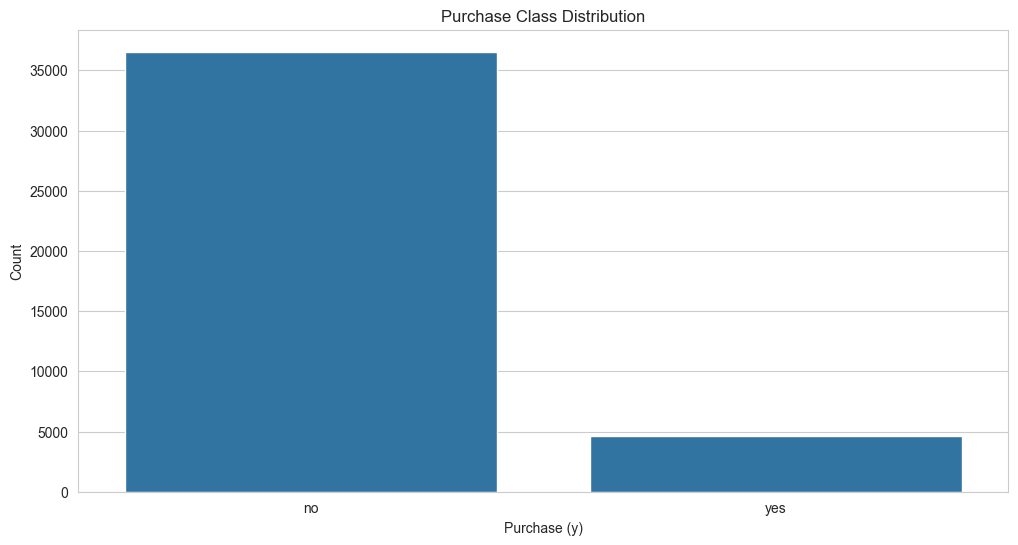

In [156]:
subscription_summary = pd.DataFrame({
    'class': counts.index,
    'count': counts.values,
    'percent': percent.values
})

print(subscription_summary)

sns.countplot(data=df, x='y')
plt.title('Purchase Class Distribution')
plt.xlabel('Purchase (y)')
plt.ylabel('Count')
plt.show()

As an additional check, we will calculate imbalance ratio.

In [157]:
imbalance_ratio = counts.min() / counts.max()
print(f"Imbalance ratio: {imbalance_ratio:.2f}")

Imbalance ratio: 0.13


Imbalance ratio is 0.13 (below 0.2) which means there's a severe imbalance. Dataset is dominated by non-purchase cases.
Without adressing this imbalance, predictive models predicting "no purchase" would achieve high accuracy, but fail to identify potential buyers.

To handle class imbalance we will use SMOTE combined with Tomek Links technique later on in paragraph `3.4.4`.

#### Univariate analysis
In the next step, we will extract numerical and categorical features from the dataset for separate analysis.

In [158]:
numericFeatures = list(df.select_dtypes(include='number').columns)
categFeatures = list(set(df.columns) - set(numericFeatures))

# Remove goal attribute
goalAttrib = df.columns.values.tolist()[-1]
if goalAttrib in categFeatures:
    categFeatures.remove(goalAttrib)
elif goalAttrib in numericFeatures:
    numericFeatures.remove(goalAttrib)
    
print(len(numericFeatures)," Numeric Features: ",numericFeatures)
print(len(categFeatures)," Categorical Features: ",categFeatures)

10  Numeric Features:  ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
10  Categorical Features:  ['marital', 'job', 'education', 'month', 'housing', 'day_of_week', 'contact', 'loan', 'default', 'poutcome']


Numerical features: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

Categorical features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

#### Feature distribution analysis

Now we will perform feature distribution analysis to examine how the data values are spread across the dataset. We will use plots and histograms to visualise the distributions of categorical and numerical features. Box plots for numerical features will be skipped in this step, as they will be specifically used for outlier detection in paragraph `2.4.2`.

In [159]:
def categ_feat_distribution():
    nrows = math.ceil(len(categFeatures) / 2)
    ncols = 2

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, nrows * 5))

    axes = axes.flatten() if len(categFeatures) > 1 else [axes]

    for i, col in enumerate(categFeatures):
        df[col].value_counts().plot(kind='bar', ax=axes[i])
        axes[i].set_title(f'{col} Counts')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Count')

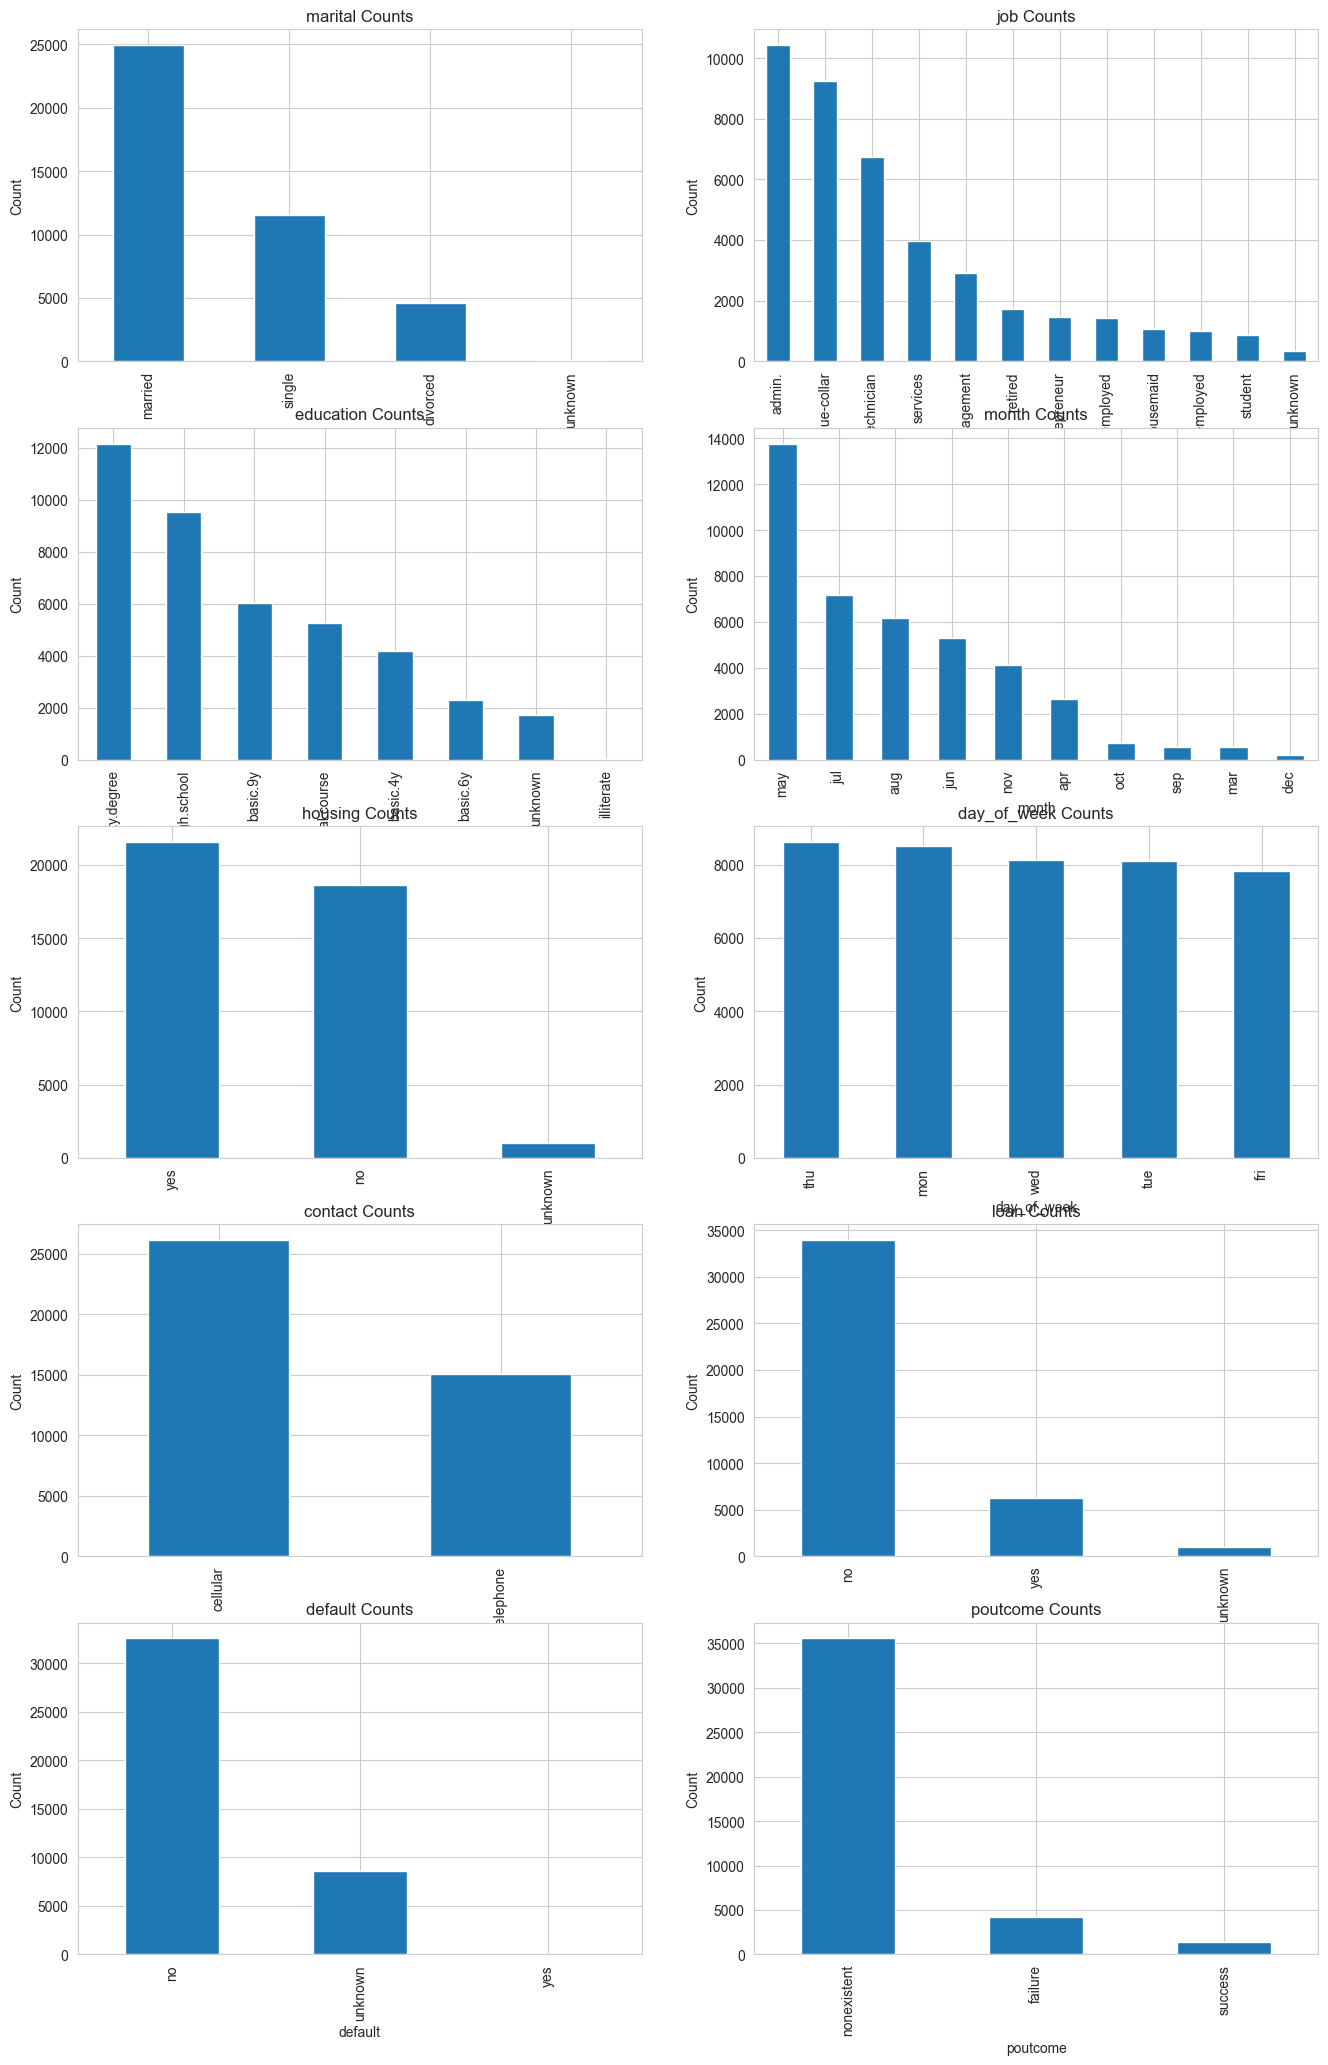

In [160]:
categ_feat_distribution()

There are 'unknown' values present in several catagorical features, which represent missing data, which, in turn, distorts statistical summaries. Because of this we will revisit and redo this analysis after `Data Cleaning` to ensure accuracy.

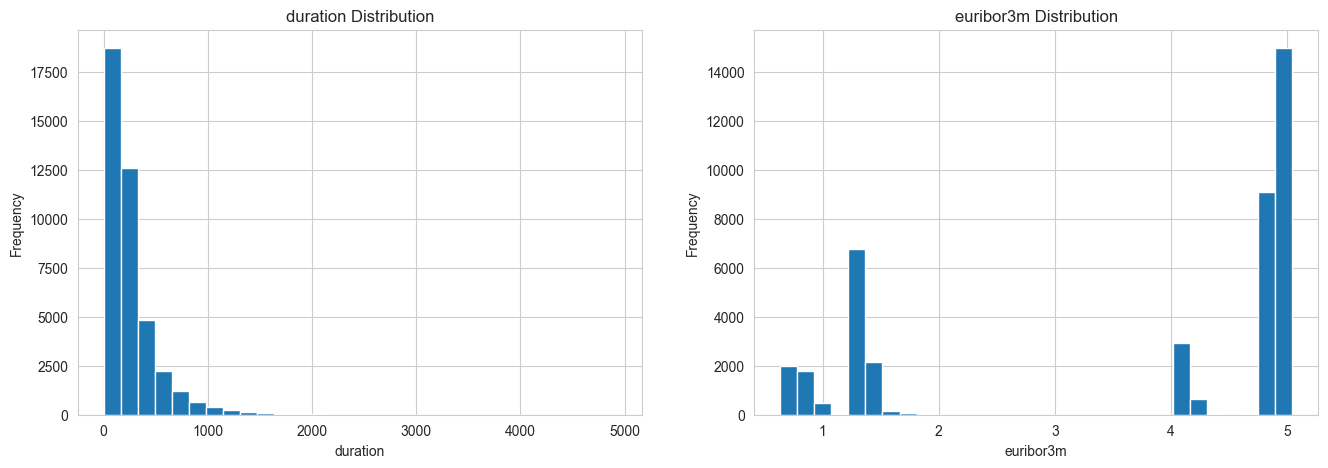

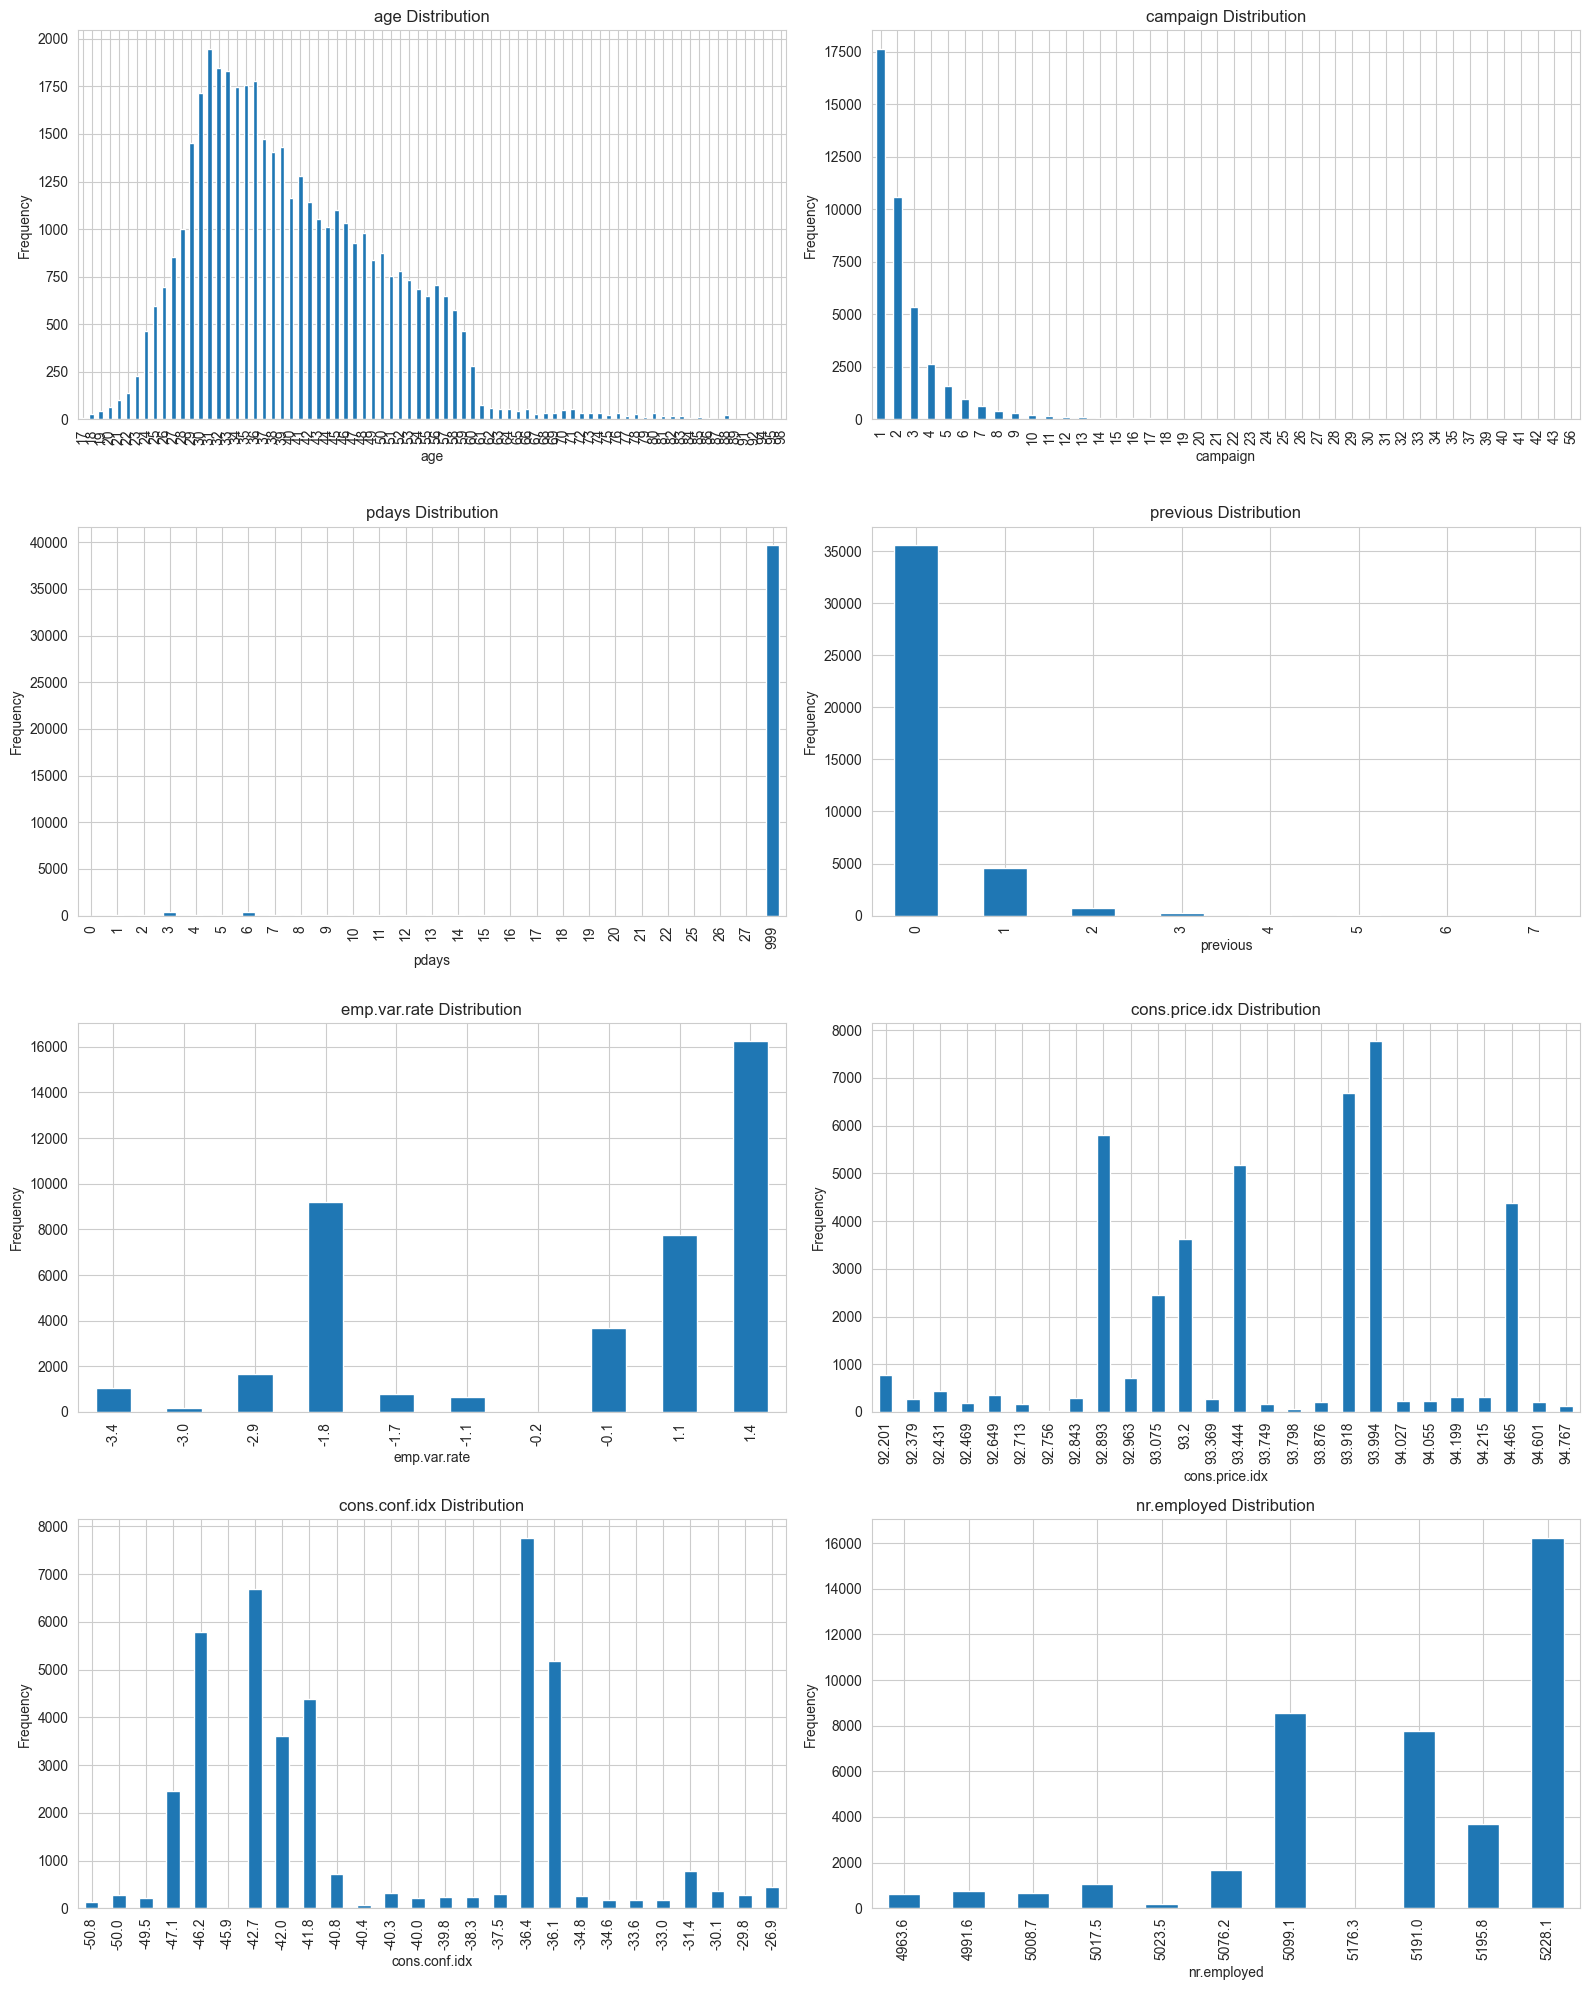

In [161]:
nonDiscreteFeatures = ['duration', 'euribor3m']
discreteFeatures = [f for f in numericFeatures if f not in nonDiscreteFeatures]

# histograms for continous featueres
nrows = math.ceil(len(nonDiscreteFeatures) / 2)
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, nrows * 5))
axes = axes.flatten()

for i, col in enumerate(nonDiscreteFeatures):
    df[col].hist(bins=30, ax=axes[i])
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.show()

# bar plot for discrete features
nrows = math.ceil(len(discreteFeatures) / 2)
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, nrows * 5))
axes = axes.flatten()

for i, col in enumerate(discreteFeatures):
    counts = df[col].value_counts().sort_index()
    counts.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Hide unused axes
for j in range(len(discreteFeatures), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


None of the numerical features has normal distribution. Only *age* distribution is close to normal distribution. *duration*, *campaign* and *previous* are strongly skewed to the right, whereas *euribor3m* and *nr.employed* are very slightly skewed to the left. *emp.var.rare*, *cons.conf.idx* and it can be ignored.
Variablies with skewed distribution will be handled in paragraph `3.4.3` to avoid issues with distance-based models used in paragraph `4.2`.

*pdays* distribution is not accurate because of '999' value which indicates that the client hasn't been called before. There is a huge spike at 999, which inidicates that many clients are new targets for the campaign. Therefore, for more detailed interpretation, the analysis of this feature will be conducted again after `Data Cleaning`.

The data represented by other variables is highly variable with clusters at different value ranges and lots of fluctuations in frequency.

In [162]:
skewed_cols = ['duration', 'campaign', 'previous']

### 2.4 Data Quality Assessment

#### 2.4.1 Identify missing values

In the first place, we will check for missing values to ensure data completeness and avoid potential issues during analysis and modeling.

In [163]:
# % missing values by column

nulls = df.isnull().sum()
percent = round(nulls/df.shape[0]*100,3)
nullvalues = pd.concat([nulls,percent], axis=1, keys=('Cont','%'))
nullvalues
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

Since there are no empty cells and 'unknown' value indicates a missing value, `df.isnull()` cannot be used. It will return information that there are no missing values, hence the cells with 'unknown' must be checked manually (and not using a pre-build function).

In [164]:
def check_unknown():
    categorical_cols_with_unknown = ['job', 'marital', 'education', 'default', 'housing', 'loan']
# Count 'unknown' in each column
    unknown_counts = {col: (df[col] == 'unknown').sum() for col in categorical_cols_with_unknown}
    unknown_df = pd.DataFrame.from_dict(unknown_counts, orient='index', columns=['Count'])
    unknown_df['Percent'] = round(unknown_df['Count'] / df.shape[0] * 100, 3)
    print(unknown_df)

In [165]:
check_unknown()

           Count  Percent
job          330    0.801
marital       80    0.194
education   1731    4.203
default     8597   20.873
housing      990    2.404
loan         990    2.404


Columns *job*, *marital*, *education*, *default*, *housing* and *loan*, as indicated in the `bank-information.txt` file, contain missing values labaled as 'unknown'. 

The frequency of 'unknown' entries varies across columns, with *default* having the highest proportion at 20.87% (8,597 entries), followed by *education* at 4.20% (1,731 entries), *housing* and *loan* both at 2.40% (990 entries each), *job* at 0.80% (330 entries), and *marital* at 0.19% (80 entries).

#### 2.4.2 Identify outliers

Based on dataframe information in `paragraph 2.2` there might be potential outliers such as clients contacted up to 56 times in the *capmaign* variable. It can disproportionately influence analysis and model results.
That's why now we will identify outliers.

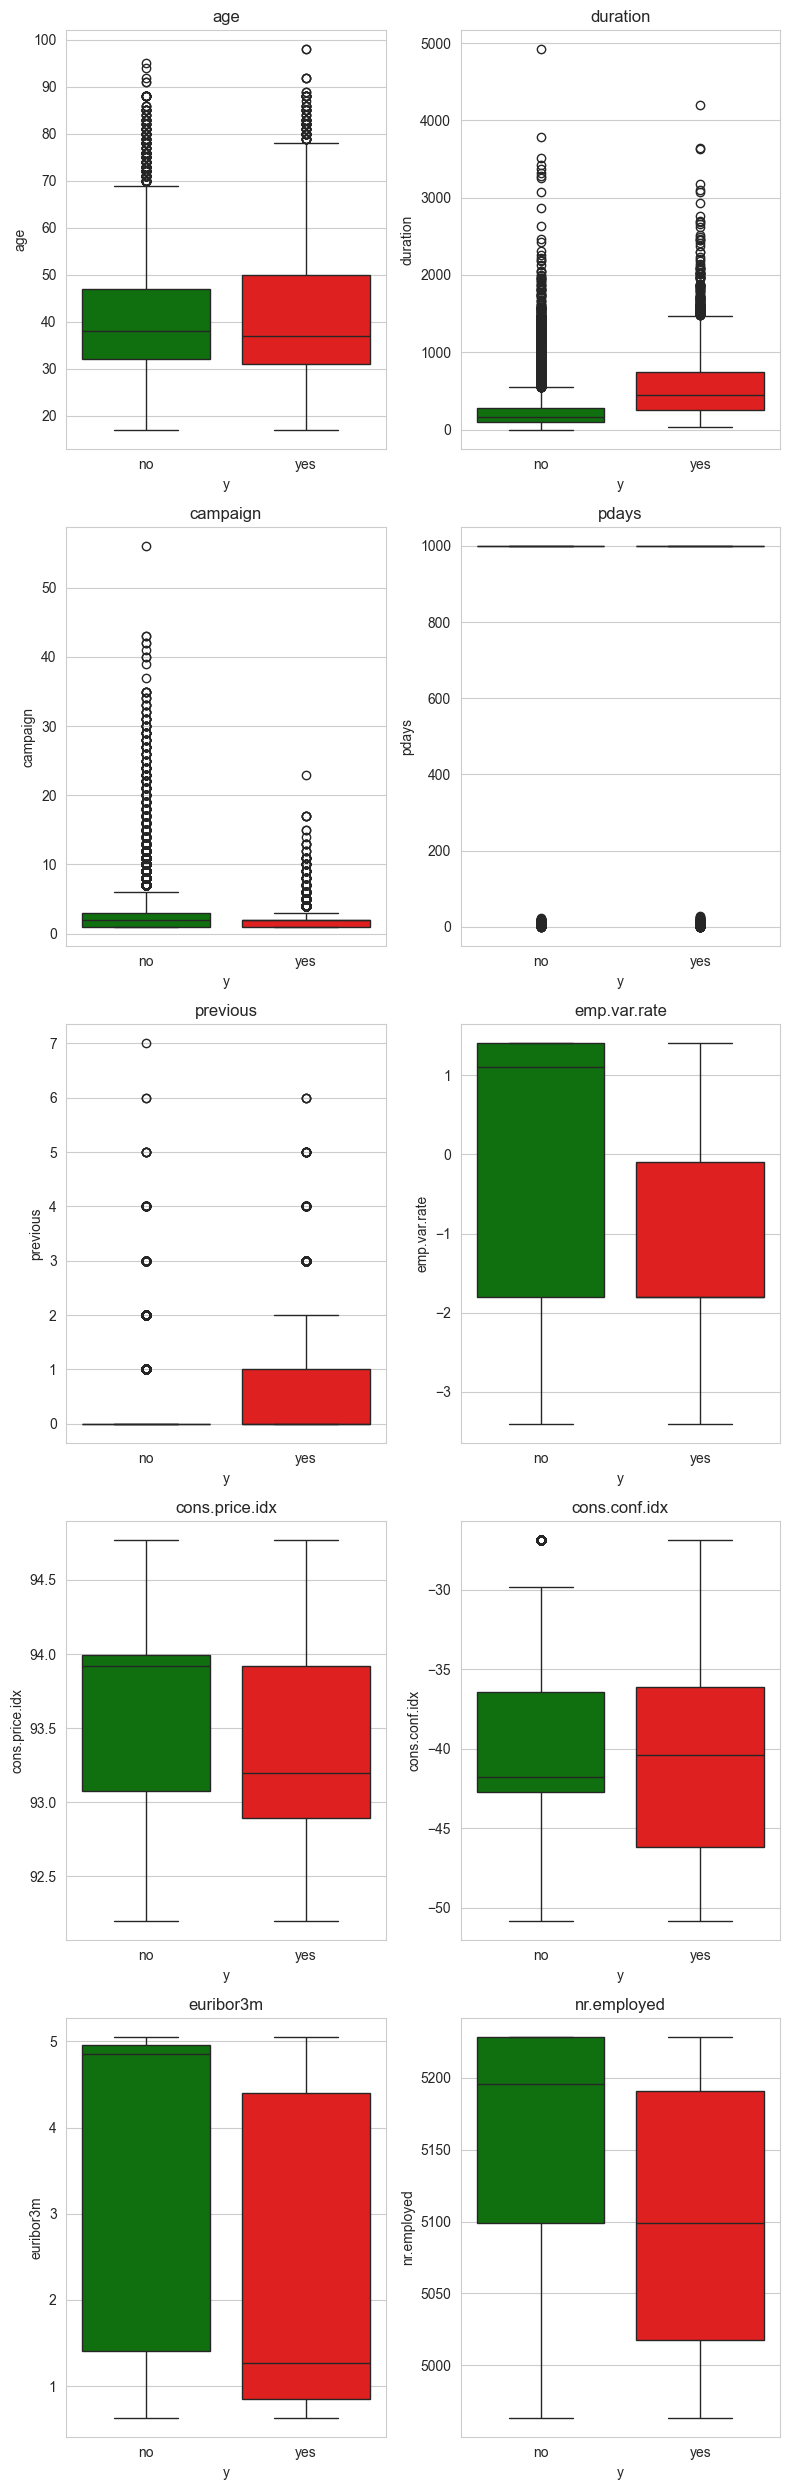

In [166]:
num_plots = len(numericFeatures)
cols = 2
rows = math.ceil(num_plots / cols)

plt.figure(figsize=(cols * 4, rows * 5)) 

for i, feature in enumerate(numericFeatures):
    plt.subplot(rows, cols, i + 1)
    sns.boxplot(data=df, x='y', y=feature, hue='y', palette={"yes": "red", "no": "green"})
    plt.title(feature)

plt.tight_layout()
plt.show()


In [167]:
Q1 = df[numericFeatures].quantile(0.25)
Q3 = df[numericFeatures].quantile(0.75)
IQR = Q3 - Q1

outliers = ((df[numericFeatures] < (Q1 - 1.5 * IQR)) | (df[numericFeatures] > (Q3 + 1.5 * IQR)))
print("Number of outliers per numeric feature:")
print(outliers.sum())

outliers_cols = outliers.any()
outliers_cols = outliers_cols[outliers_cols].index.tolist()
print("\nColumns containing outliers:")
print(outliers_cols)

Number of outliers per numeric feature:
age                469
duration          2963
campaign          2406
pdays             1515
previous          5625
emp.var.rate         0
cons.price.idx       0
cons.conf.idx      447
euribor3m            0
nr.employed          0
dtype: int64

Columns containing outliers:
['age', 'duration', 'campaign', 'pdays', 'previous', 'cons.conf.idx']


We performed outliers detection on all numerical features using the Interquartile Range (IQR) method and visualized it using boxplots.

Features such as *previous*, *duration* and *campaign* contained a high number of outlier values.
*age* and *pdays* alco contained a noticeable number out outliers.
Several features, including *emp.var.rate*, *cons.price.idx*, *e8uribor3m* and *nr.employed*, showed no outliers according to the IQR method.

#### 2.4.3 Check data duplication

The next step is to check for data duplication, because duplicate records can cause biased insights and reduce the effectiveness of the model. Removing duplicates helps maintain the integrity of the data and ensures that each observation contributes uniquely to the analysis.

In [168]:
df.duplicated().sum()

np.int64(12)

There are 12 duplicated rows.

---
## 3. Data Preparation

### 3.1 Data Cleaning

#### 3.1.1 Missing values

The first thing to be perfomed is to handle missing values indicated in paragraph `2.4.1`.

For the attributes with very small number of missing values, namely, *job*, *marital*, *housing* and *loan*, the rows with the missing values will be dropped.

In [169]:
impute_cols = ['job', 'marital', 'housing', 'loan']

df = df[~df[impute_cols].isin(['unknown']).any(axis=1)]

In [170]:
# check_unknown()

For *education*, the missing values will be replaced with the most common value in the dataset for this variable. This approach is chosen because imputing with the mode preserves the existing distribution of categories without introducing bias from rare categories and it is effective with the small number of missing entries.

In [171]:
most_common = df.loc[df['education'] != 'unknown', 'education'].mode()[0]
df.loc[df['education'] == 'unknown', 'education'] = most_common
print(f"Imputed 'unknown' in '{'education'}' with: {most_common}")

Imputed 'unknown' in 'education' with: university.degree


In [172]:
# check_unknown()

The variable default contains a substantial number of missing values (approximately 20%). To address this, we apply a **logistic regression** model to impute the missing entries by predicting them based on the available data.

Before modeling, the dataset must be properly encoded, following the steps described in Sections 3.4.1 and 3.4.2. To avoid modifying the original data during preprocessing, we work on a copy of the dataset. Once the missing values have been predicted, we use these results to update the original dataset.

In [173]:
df_temp = df.copy()
missing_mask = df_temp['default'] == 'unknown'

Binary encoding:

In [174]:
def encode_categ_feat(dataset, cols):
    for feature in cols:
        print(feature)
        print(dataset[feature].unique())
        if dataset[feature].dropna().isin(['yes', 'no']).all():
            dataset[feature] = (dataset[feature].values == 'yes').astype(int)
            print(dataset[feature].unique())

In [175]:
encode_categ_feat(dataset=df_temp, cols=categFeatures)

marital
['married' 'single' 'divorced']
job
['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'entrepreneur' 'student']
education
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'university.degree' 'illiterate']
month
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
housing
['no' 'yes']
[0 1]
day_of_week
['mon' 'tue' 'wed' 'thu' 'fri']
contact
['telephone' 'cellular']
loan
['no' 'yes']
[0 1]
default
['no' 'unknown' 'yes']
poutcome
['nonexistent' 'failure' 'success']


Conversion of categorical variables:

In [176]:
df_temp = pd.get_dummies(df_temp, drop_first=True, dtype=int)

df_temp.rename({'default_yes': 'default'}, axis='columns', inplace = True)
df_temp.drop(columns='default_unknown', inplace=True)

In [177]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39803 entries, 0 to 41187
Data columns (total 48 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            39803 non-null  int64  
 1   housing                        39803 non-null  int64  
 2   loan                           39803 non-null  int64  
 3   duration                       39803 non-null  int64  
 4   campaign                       39803 non-null  int64  
 5   pdays                          39803 non-null  int64  
 6   previous                       39803 non-null  int64  
 7   emp.var.rate                   39803 non-null  float64
 8   cons.price.idx                 39803 non-null  float64
 9   cons.conf.idx                  39803 non-null  float64
 10  euribor3m                      39803 non-null  float64
 11  nr.employed                    39803 non-null  float64
 12  job_blue-collar                39803 non-null  int6

In [178]:
df_temp.loc[:,'pdays'] = df_temp['pdays'].replace(999, -1)

In [179]:
df_temp.insert(
    loc = df_temp.columns.get_loc('pdays') + 1,  # insert after 'pdays'
    column = 'never_contacted',
    value = (df_temp['pdays'] == -1).astype(int)
)

The data has been cleaned, now we can perform logistic regression.

In [180]:
train_df = df_temp.loc[~missing_mask]
impute_df = df_temp.loc[missing_mask]

X_train = train_df.drop(columns=['default'])
y_train = train_df['default']

X_impute = impute_df.drop(columns=['default'])

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

predicted_defaults = model.predict(X_impute)

df.loc[missing_mask, 'default'] = predicted_defaults

#### 3.1.2 Duplicates Deletion

Then we will delete duplicates to avoid redundancy of data, as indicated in paragraph `2.4.3`.

In [181]:
# Remove duplicate lines, if they exist

shape_before = df.shape
print('Shape before deleting duplicate values:',shape_before)

df = df.drop_duplicates()

shape_after = df.shape
print('Shape after deleting duplicate values:',shape_after)

percent = round((1-shape_after[0]/shape_before[0])*100,3)
print(f"Percentage of duplicates rows droped: {percent}%")

Shape before deleting duplicate values: (39803, 21)
Shape after deleting duplicate values: (39791, 21)
Percentage of duplicates rows droped: 0.03%


#### 3.1.3 Outliers Removal

To remove outliers identified in paragraph `2.4.2` we will use **Robust Scaler** during `Data Transformation` in paragraph `3.3`.


#### Data Exploration of cleaned dataset

In [182]:
for col in df.select_dtypes(include='object').columns:
    print(f"{col} unique values: {df[col].unique()}")

job unique values: ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'entrepreneur' 'student']
marital unique values: ['married' 'single' 'divorced']
education unique values: ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'university.degree' 'illiterate']
default unique values: ['no' 0 'yes']
housing unique values: ['no' 'yes']
loan unique values: ['no' 'yes']
contact unique values: ['telephone' 'cellular']
month unique values: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
day_of_week unique values: ['mon' 'tue' 'wed' 'thu' 'fri']
poutcome unique values: ['nonexistent' 'failure' 'success']
y unique values: ['no' 'yes']


Based on the information about unique values there were no inconsistencies to be fixed, however we will change value '999' in *pdays* variable to '-1'.

In [183]:
# Replace 999 with -1 to mark 'never contacted'
df.loc[:,'pdays'] = df['pdays'].replace(999, -1)

Now we will redo the distribution analysis for categorical features and *pdays* variable.

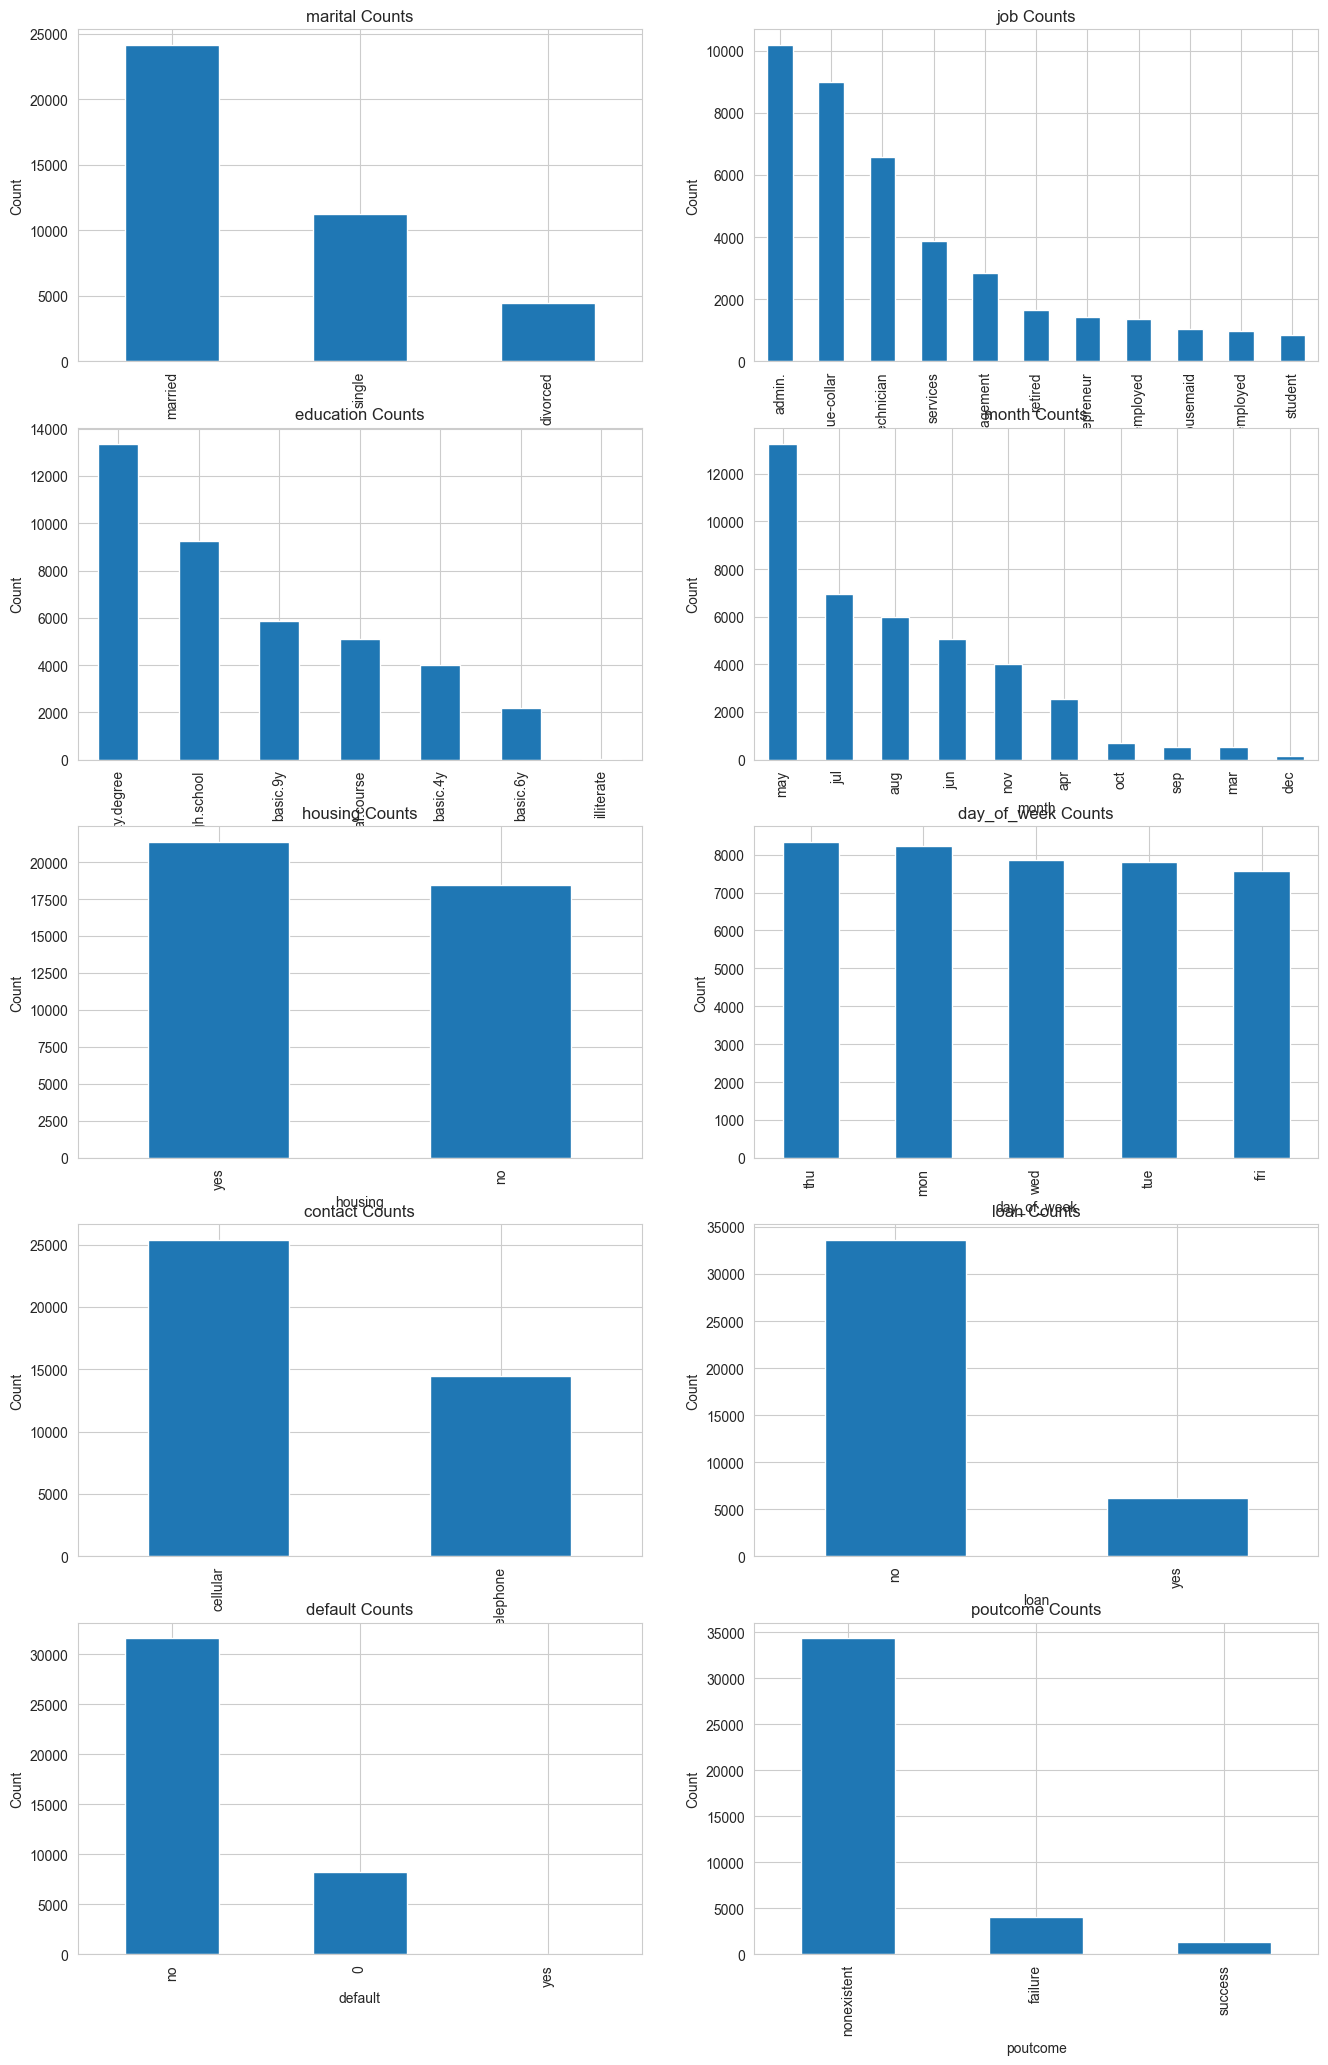

In [184]:
categ_feat_distribution()

Almost every variable is dominated by one group. The loan status shows a strong imbalance with most of the clients not having a loan. Similarly, *default* is strongly dominated with 'no' with only few 'yes' entries. *job* variable is dominated by 'admin', education by 'university.degree', *contact* by 'cellular', *marital* by 'married' and *month* by 'may'. Only values of *housing* and *day_of_week* are distributed similarly.

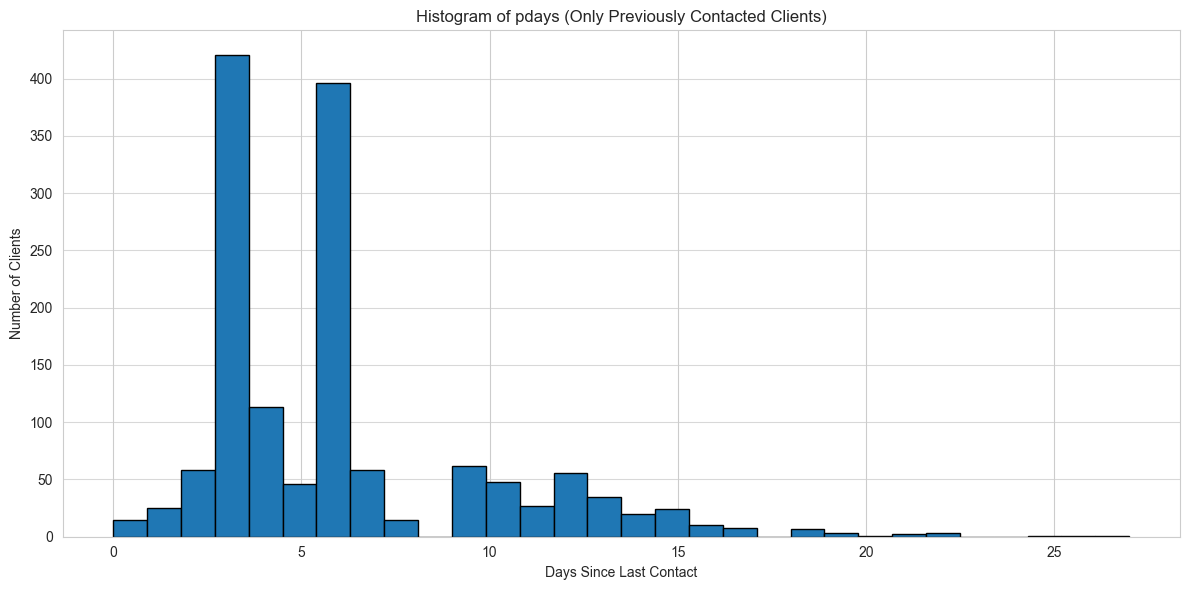

In [185]:
plt.figure(figsize=(12, 6))

# Filter out -1 (i.e., only keep rows where pdays != -1)
plt.hist(df[df['pdays'] != -1]['pdays'], bins=30, edgecolor='black')

plt.title('Histogram of pdays (Only Previously Contacted Clients)')
plt.xlabel('Days Since Last Contact')
plt.ylabel('Number of Clients')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

We omitted '-1' values for the analysis purposes. 
*pdays* variable is not severly skewed but has two peaks.


### 3.2 Bivariate analysis

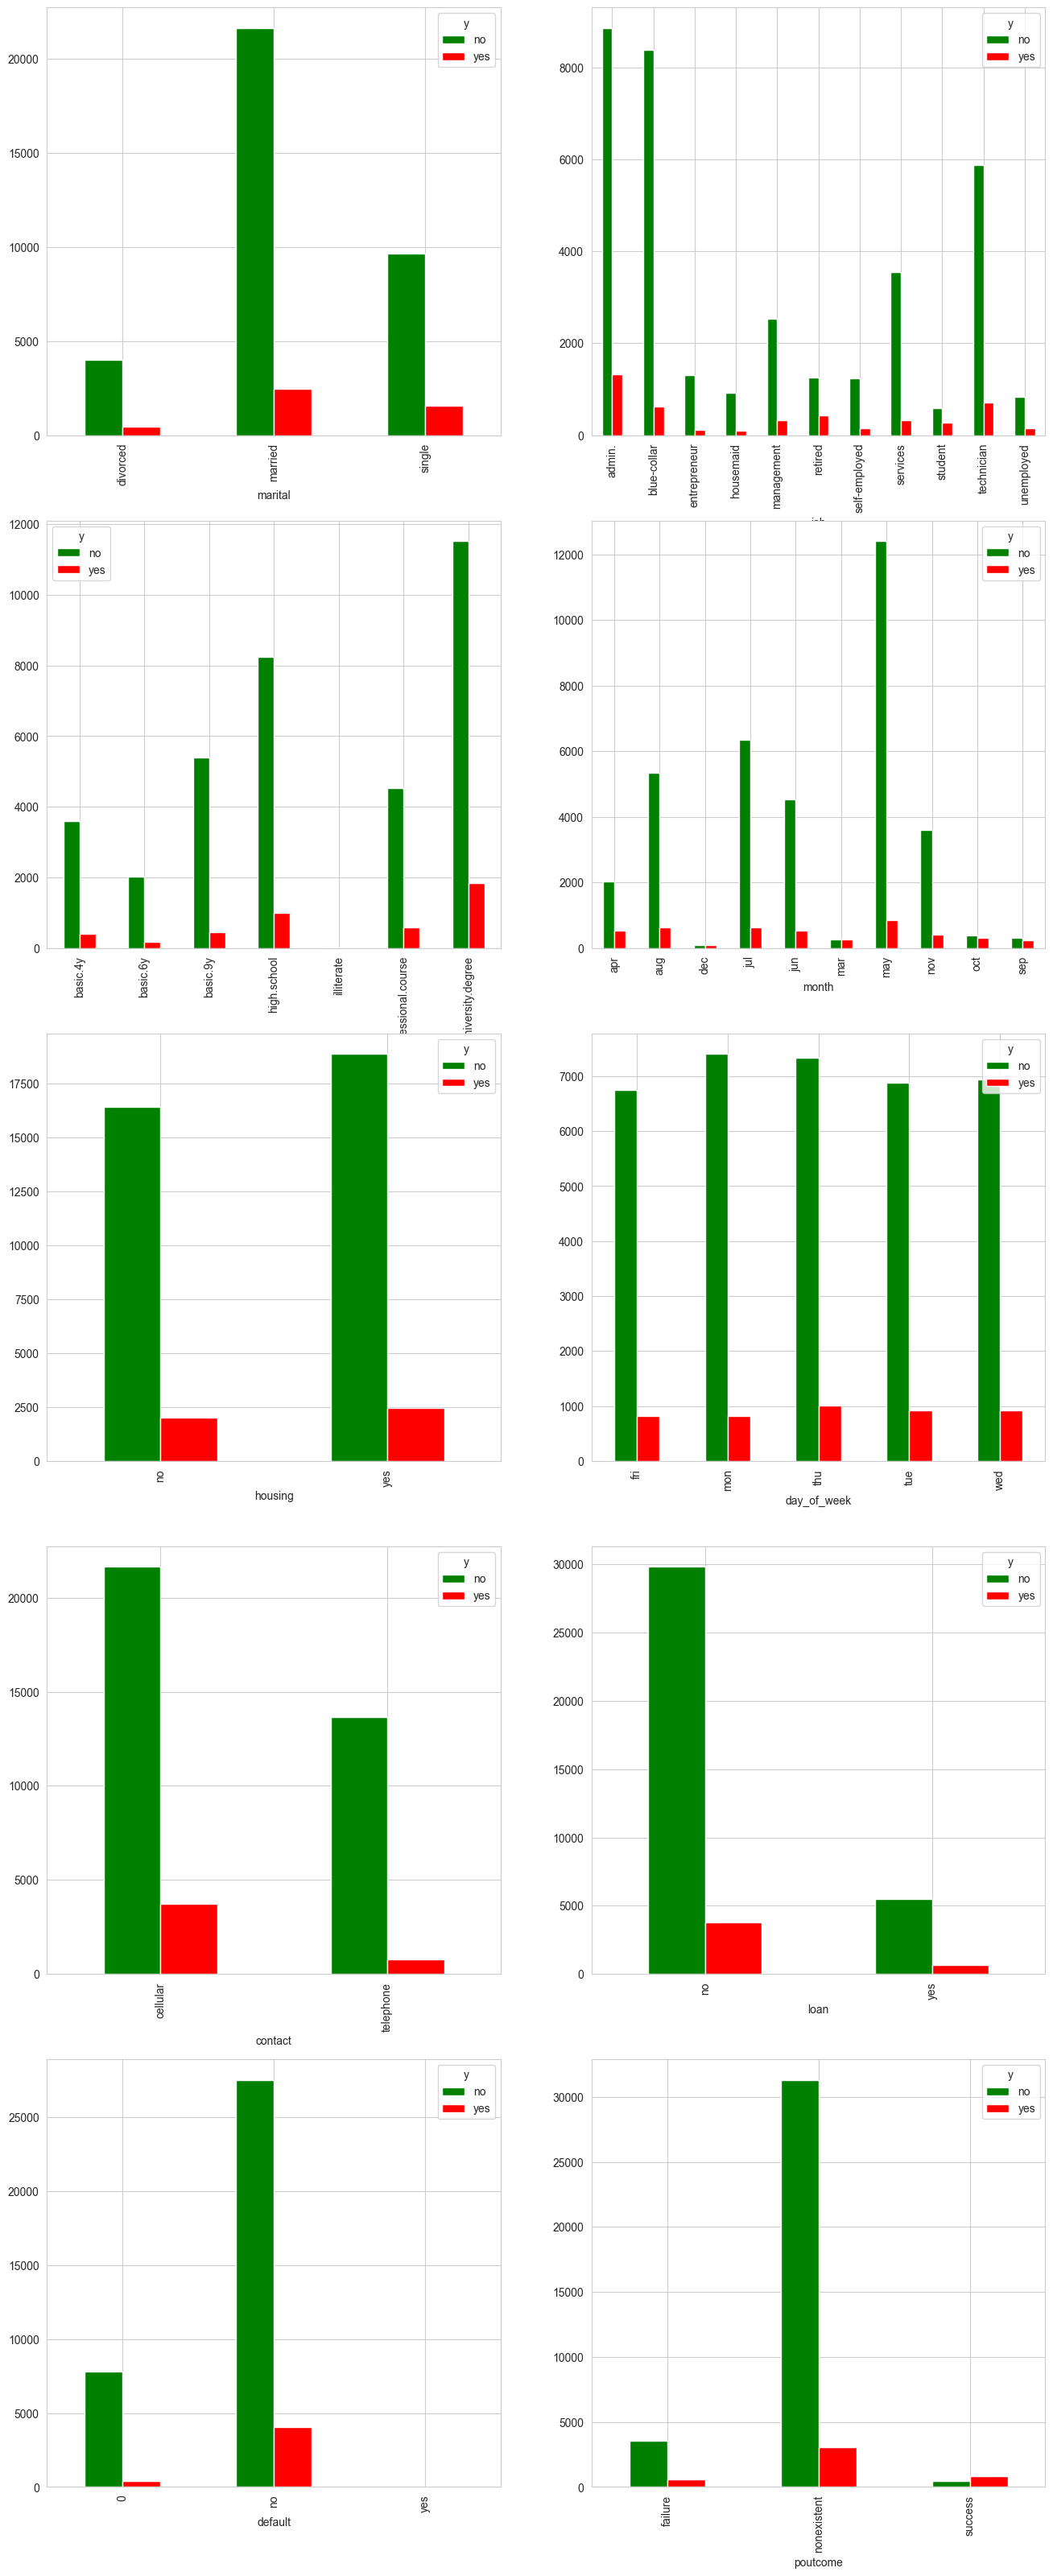

In [186]:
fig, PlotCanvas = plt.subplots(nrows=math.ceil(len(categFeatures)/2), ncols=2, figsize=(16, 40))

# Creating Grouped bar plots for each categorical predictor against the Target Variable "class"
lin = 0
for i, Categcol in enumerate(categFeatures):
    col = i%2   
    CrossTabResult=pd.crosstab(index=df[Categcol], columns=df['y'])
    CrossTabResult.plot.bar(color=['green','red'], ax=PlotCanvas[lin,col])
    if i%2 == 1:
        lin = lin+1
    

These grouped bar charts display the frequency on the Y-axis and the category values on the X-axis. If the proportions of the target variable (e.g., 'yes' vs. 'no') are similar across all categories of a feature, it suggests that there is little to no relationship between that feature and the target.

For example, if we look at a hypothetical plot like *day of week* vs. *y*, and observe that each day of a week has a similar 'yes' to 'no' ratio, it indicates that the day of week likely has no significant influence on *y*. In such cases, the feature and the target variable are likely not correlated. It can be also observed on the plot depicting *default* vs. *y*, *housing* vs. *y* and *loan* vs. *y*, which means that *default*, *housing* and *loan* are likely not correlated to *y*. 

However, there are a few variables that seems to be strongly correlated to *y*. Namely, *marital*, *poutcome*, *contact*, *job* and *education*. These variables do not maintain consistent proportions across the target classes.

In [ ]:
num_features = len(numericFeatures)
cols = 3
rows = math.ceil(num_features / cols)

# histograms for continous data
plt.figure(figsize=(5 * cols, 4 * rows))

for i, feature in enumerate(nonDiscreteFeatures): 
    plt.subplot(rows, cols, i + 1)
    if feature == 'pdays':
        sns.histplot(data=df[df['pdays'] != -1], x='pdays', hue='y', kde=True, bins=30, palette={"yes": "red", "no": "green"})
    else:
        sns.histplot(df, x=feature, hue='y', kde=True, bins=30, palette={"yes": "red", "no": "green"})
    plt.title(feature)

plt.tight_layout()
plt.show()

print(discreteFeatures)
    
# bar plot for discrete features

nrows = math.ceil(len(discreteFeatures) / 2)
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, nrows * 5))
axes = axes.flatten()  # flatten for easy linear indexing

for i, Categcol in enumerate(discreteFeatures):
    ax = axes[i]
    CrossTabResult = pd.crosstab(index=df[Categcol], columns=df['y'])
    CrossTabResult.plot.bar(color=['green', 'red'], ax=ax)
    ax.set_title(f'{Categcol} Distribution')
    ax.set_xlabel(Categcol)
    ax.set_ylabel('Frequency')

# Hide any unused axes
for j in range(len(discreteFeatures), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

Every variable except for *pdays* is dominated by 'no' class and *pdays* is dominated by 'yes' class, which means all of the variables are relevant for the predictions.

### 3.4 Data Transformation

#### 3.4.1 Encoding categorical variables

To enable models to use the dataframe, data transformation, including encoding categorical variables must be conducted. Each variable with only two values ('yes' and 'no' in this dataframe) will be changed to '1' and '0'.

In [ ]:
dfML = df.copy()

engineerNumericFeatures = list(dfML.select_dtypes(include='number').columns)
engineerCategFeatures = list(set(dfML.columns) - set(numericFeatures))

encode_categ_feat(dataset=dfML, cols=engineerCategFeatures)

dfML.info()

marital
['married' 'single' 'divorced']
y
['no' 'yes']
[0 1]
job
['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'entrepreneur' 'student']
education
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'university.degree' 'illiterate']
month
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
housing
['no' 'yes']
[0 1]
day_of_week
['mon' 'tue' 'wed' 'thu' 'fri']
contact
['telephone' 'cellular']
loan
['no' 'yes']
[0 1]
default
['no' 0 'yes']
poutcome
['nonexistent' 'failure' 'success']
<class 'pandas.core.frame.DataFrame'>
Index: 39791 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             39791 non-null  int64  
 1   job             39791 non-null  object 
 2   marital         39791 non-null  object 
 3   education       39791 non-null  object 
 4   default         39791 non-null  object

#### 3.4.2 Feature Engineering

We will perform feature engineering alongside data transformation, because we had to first encode the categorical values.

There are a lot of categorical variables with multiple possible values. We will use `get_dummies()` function to one-hot encode them. This allows models that require numerical input to process categorical data effectively.

In [ ]:
dfML = pd.get_dummies(dfML, drop_first=True, dtype=int)

dfML.rename({'y_yes': 'y'}, axis='columns', inplace = True)

dfML.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39791 entries, 0 to 41187
Data columns (total 49 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            39791 non-null  int64  
 1   housing                        39791 non-null  int64  
 2   loan                           39791 non-null  int64  
 3   duration                       39791 non-null  int64  
 4   campaign                       39791 non-null  int64  
 5   pdays                          39791 non-null  int64  
 6   previous                       39791 non-null  int64  
 7   emp.var.rate                   39791 non-null  float64
 8   cons.price.idx                 39791 non-null  float64
 9   cons.conf.idx                  39791 non-null  float64
 10  euribor3m                      39791 non-null  float64
 11  nr.employed                    39791 non-null  float64
 12  y                              39791 non-null  int6

We will also create a new variable - *never_contacted* - related to the variables: *previous* and *pdays*. Value '1' will indicate that the client has never been called by another campaign.

In [ ]:
dfML.insert(
    loc = dfML.columns.get_loc('pdays') + 1,  # insert after 'pdays'
    column = 'never_contacted',
    value = (dfML['pdays'] == -1).astype(int)
)

In [ ]:
dfML.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39791 entries, 0 to 41187
Data columns (total 50 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            39791 non-null  int64  
 1   housing                        39791 non-null  int64  
 2   loan                           39791 non-null  int64  
 3   duration                       39791 non-null  int64  
 4   campaign                       39791 non-null  int64  
 5   pdays                          39791 non-null  int64  
 6   never_contacted                39791 non-null  int64  
 7   previous                       39791 non-null  int64  
 8   emp.var.rate                   39791 non-null  float64
 9   cons.price.idx                 39791 non-null  float64
 10  cons.conf.idx                  39791 non-null  float64
 11  euribor3m                      39791 non-null  float64
 12  nr.employed                    39791 non-null  floa

#### 3.4.3 Handling variables with skewed distribution

Since not all of the skewed distrubutions concern variables with positive values we will use **Yeo-Johnson** scaler.

In [ ]:
# Cast to float before transformation to avoid dtype issues
cols_to_convert = skewed_cols + outliers_cols
dfML = dfML.copy()

for col in cols_to_convert:
    dfML[col] = dfML[col].astype(float)

In [ ]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')

print(df[skewed_cols].dtypes)

dfML.loc[:, skewed_cols] = pt.fit_transform(dfML.loc[:, skewed_cols])

duration    int64
campaign    int64
previous    int64
dtype: object


#### 3.4.4 Handling outliers

As indicated in paragraph `3.1`, we will use **Robust Scaler** to handle outliers.

In [ ]:
# Feature scaling

# Initialize the scaler
scaler = RobustScaler()

print(outliers_cols)
print(type(outliers_cols))

# Fit the scaler on the numeric features and transform
dfML.loc[:,outliers_cols] = scaler.fit_transform(dfML[outliers_cols])

['age', 'duration', 'campaign', 'pdays', 'previous', 'cons.conf.idx']
<class 'list'>


#### 3.4.5 Dropping unnecessary variables

We will drop *duration* variable since it highly affects the otput target, yet the value is not known before the class is made.

In [ ]:
dfML.drop(columns='duration', axis=1, inplace=True)

### 3.5 Data Splitting

To evaluate the models used in paragraph `4` we have to split dataset into a train and a test set. We will use an 80/20 split ratio to ensure sufficient amount of data for training while retaining enough samples for meaningful evaluation.
Additionally, stratified sampling will applied to preserve the distribution of the target variable across both subsets, preventing bias during model evaluation.

In [ ]:
X = df.drop(columns=['y','duration'])
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Original dataframe
# Combine features and target for training set
train_df = X_train.copy()
train_df['y'] = y_train

# Combine features and target for testing set
test_df = X_test.copy()
test_df['y'] = y_test


# This second dataframe is processed

X = dfML.drop(columns=['y'])
y = dfML['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_imbalance = X_train.copy()
train_imbalance['y'] = y_train


To address class imbalance we will apply **SMOTETomek method**, a hybrid sampling technique that combines SMOTE (Synthetic Minority Over-sampling Technique) and Tomek links cleaning. This helps create a clearer separation between classes, which enables the model to learn more effectively and improve its ability to correctly identify minority class instances.

In [ ]:
smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

In [ ]:
train_dfML = X_train_resampled.copy()
train_dfML['y'] = y_train_resampled

test_dfML = X_test.copy()
test_dfML['y'] = y_test

### 3.5 Feature Selection

By choosing only important features, model complexity is reduced and training efficiency is improved. To handle that we will use both filter and embedded methods.

#### 3.5.1 Filter Methods

**Statistical Feature Selection**

* Categorical vs Continuous---- ANOVA test
* Categorical vs Categorical--- Chi-Square test

**Categorical vs categorical using Chi-Square Test**

Chi-Square test is conducted to check the correlation between two categorical variables
 - Assumption(H0): The two columns are NOT related to each other
 - Result of Chi-Sq Test: The Probability of H0 being True

In [ ]:
def FunctionChisq(inpData, TargetVariable, CategoricalVariablesList):
    # Creating an empty list of final selected predictors
    FiltPredictors=[]

    for predictor in CategoricalVariablesList:
        CrossTabResult=pd.crosstab(index=inpData[TargetVariable], columns=inpData[predictor])
        ChiSqResult = chi2_contingency(CrossTabResult)
        
        # If the ChiSq P-Value is <0.05, that means we reject H0
        if (ChiSqResult[1] < 0.05):
            print(predictor, 'is correlated with', TargetVariable, '| P-Value:', ChiSqResult[1])
        else:
            print(predictor, 'is NOT correlated with', TargetVariable, '| P-Value:', ChiSqResult[1]) 
            FiltPredictors.append(predictor)
            
    return(FiltPredictors)

In [ ]:
newCategFeatures = []
for categCol in categFeatures:
    newCategFeatures.extend([col for col in dfML.columns if col.startswith(categCol)])

print(numericFeatures)
newNumericFeatures = numericFeatures
newNumericFeatures.remove('duration')

print('Categorical Features:', newCategFeatures)
print('Numerical Features:', newNumericFeatures)

['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


ValueError: list.remove(x): x not in list

In [ ]:
filterCateg = FunctionChisq(inpData=train_dfML, TargetVariable='y', CategoricalVariablesList=newCategFeatures)

marital_married is correlated with y | P-Value: 7.151874793511775e-186
marital_single is correlated with y | P-Value: 7.088674197417727e-16
job_blue-collar is correlated with y | P-Value: 0.0
job_entrepreneur is correlated with y | P-Value: 2.3966915220259306e-113
job_housemaid is correlated with y | P-Value: 4.170625309963331e-78
job_management is correlated with y | P-Value: 5.210235977985115e-84
job_retired is correlated with y | P-Value: 4.423504970743704e-80
job_self-employed is correlated with y | P-Value: 8.669798879613797e-70
job_services is correlated with y | P-Value: 1.8423590199114297e-197
job_student is correlated with y | P-Value: 2.3904257312355888e-28
job_technician is correlated with y | P-Value: 6.795289426204947e-153
job_unemployed is correlated with y | P-Value: 1.0788358682245728e-45
education_basic.6y is correlated with y | P-Value: 5.6558064831593186e-96
education_basic.9y is correlated with y | P-Value: 4.436562837207894e-255
education_high.school is correlated 

The Chi-square test proves that *default_yes* is not correlated with y, which was shown on the plots (3.2). *education_illiterate* is also not correlated.

**Continuous vs categorical using ANOVA test**
 
   - Assumption(H0): There is NO relation between the given variables (i.e. the average(mean) values of the numeric    predictor variable is same for all the groups in the categorical Target variable)

ANOVA Test result: Probability of H0 being true

In [ ]:
def FunctionAnova(inpData, TargetVariable, ContinuousPredictorList):
    # Creating an empty list of final selected predictors
    FiltPredictors=[]
    
    print('##### ANOVA Results ##### \n')
    for predictor in ContinuousPredictorList:
        # Handle special cases for predictors (e.g., exclude -1 for pdays)
        if predictor == 'pdays':
            data = inpData[inpData[predictor] != -1]
        else:
            data = inpData
        
        # Group the data by the target variable and get lists of values per group
        CategoryGroupLists = data.groupby(TargetVariable)[predictor].apply(list)
        
        # If any group is constant (only one unique value), f_oneway will raise warning or error
        # So check for constant groups and skip ANOVA if found
        if any([len(set(group)) <= 1 for group in CategoryGroupLists]):
            print(f"Skipping ANOVA for '{predictor}' because one or more groups have constant values.")
            FiltPredictors.append(predictor)  # Consider skipping or adding to filtered
            continue
        
        AnovaResults = f_oneway(*CategoryGroupLists)
        
        # If the ANOVA P-Value is <0.05, that means we reject H0 (significant)
        if AnovaResults[1] < 0.05:
            print(predictor, 'is correlated with', TargetVariable, '| P-Value:', AnovaResults[1])
        else:
            print(predictor, 'is NOT correlated with', TargetVariable, '| P-Value:', AnovaResults[1])
            FiltPredictors.append(predictor)
            
    return FiltPredictors


In [ ]:
# Calling the function to check which numeric variables are correlated with target
# df_anova = train_dfML[train_dfML['pdays'] != -1] # remove -1s


for col in newNumericFeatures:
    grouped = dfML.groupby('y')[col]
    for name, group in grouped:
        if group.nunique() <= 1:
            print(f"Feature '{col}' is constant for target group '{name}'")

filterNumeric = FunctionAnova(inpData=train_dfML, TargetVariable='y', ContinuousPredictorList = newNumericFeatures)

##### ANOVA Results ##### 

age is correlated with y | P-Value: 1.3824278809065961e-18
campaign is correlated with y | P-Value: 1.3163910657106428e-186
pdays is correlated with y | P-Value: 0.0
previous is correlated with y | P-Value: 0.0
emp.var.rate is correlated with y | P-Value: 0.0
cons.price.idx is correlated with y | P-Value: 0.0
cons.conf.idx is correlated with y | P-Value: 7.044021429311534e-78
euribor3m is correlated with y | P-Value: 0.0
nr.employed is correlated with y | P-Value: 0.0


In [ ]:
FilterColumns = filterCateg + filterNumeric

print(f"Removed features by Filter methods: {FilterColumns}")

df1 = train_dfML.copy()
df1_imbalance = train_imbalance.copy()

print(df1.columns.tolist())

df1.drop(columns=FilterColumns, axis=1, inplace=True)
df1_imbalance.drop(columns=FilterColumns, axis=1, inplace=True)

df1_test = test_dfML.copy()
df1_test.drop(columns=FilterColumns, axis=1, inplace=True)

df1.info()

Removed features by Filter methods: ['education_illiterate', 'default_yes']
['age', 'housing', 'loan', 'campaign', 'pdays', 'never_contacted', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'marital_married', 'marital_single', 'education_basic.6y', 'education_basic.9y', 'education_high.school', 'education_illiterate', 'education_professional.course', 'education_university.degree', 'default_no', 'default_yes', 'contact_telephone', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'poutcome_nonexistent', 'poutcome_success', 'y']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56146 entries, 0 to 56145
Data columns (total 47 colu

Filter methods removed two variables: *default_yes* and *education_illiterate*.

#### 3.5.2 Embedded method - Lasso regularization

In [ ]:
def lasso_regularization(df):

    X = df.iloc[:,:-1].copy()          
    y = df.iloc[:,-1].copy() 
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    scaler = StandardScaler()
    scaler.fit(X_train)

    # fit a Logistic Regression model and feature selection altogether 
    # select the Lasso (l1) penalty.
    # The selectFromModel class from sklearn, selects the features which coefficients are non-zero

    sel_ = SelectFromModel(LogisticRegression(C=0.5, penalty='l1', solver='liblinear', random_state=10))

    sel_.fit(scaler.transform(X_train), y_train)

    # make a list with the selected features
    selected_feat = X_train.columns[(sel_.get_support())]
    
    print("Number of features which coefficient was shrank to zero: ", np.sum(sel_.estimator_.coef_ == 0))
    # identify the removed features like this:
    removed_feats = X_train.columns[(sel_.estimator_.coef_ == 0).ravel().tolist()]
    print('Removed features by Lasso: ',removed_feats) 

    return X_train.columns[(sel_.estimator_.coef_ != 0).ravel().tolist()]

In [ ]:
Lasso_SelectedColumns = lasso_regularization(train_dfML)

Lasso_SelectedColumns

Number of features which coefficient was shrank to zero:  1
Removed features by Lasso:  Index(['nr.employed'], dtype='object')


Index(['age', 'housing', 'loan', 'campaign', 'pdays', 'never_contacted',
       'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_married',
       'marital_single', 'education_basic.6y', 'education_basic.9y',
       'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'default_no', 'default_yes', 'contact_telephone', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'day_of_week_mon',
       'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed',
       'poutcome_nonexistent', 'poutcome_success'],
      dtype='object')

Embedded method removed no variables, therefore we will not create a separate dataset.

With these methods, we prepared a dataframes for future testing and tuning to compare different models and select the one with the best performance.

---
## 4. Modeling

### 4.1 Evaluation metric selection

The ccc

In [ ]:
baseline = df1_test['y'].mean()
print(baseline)

0.1127026008292499


### 4.2 Baseline models

In [ ]:
X_train_model = df1.drop(columns=['y'])
y_train_model = df1['y']
X_train_imb = df1_imbalance.drop(columns=['y'])
y_train_imb = df1_imbalance['y']

X_test_model = df1_test.drop(columns=['y'])
y_test_model = df1_test['y']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_model)
X_test_scaled = scaler.transform(X_test_model)
results = []

In [ ]:
def add_or_replace_result(model_name, new_result):
    for i, r in enumerate(results):
        if r['Model'] == model_name:
            results[i] = new_result
            return
    results.append(new_result)

In [ ]:
def evaluation(model_name, y_pred, y_proba, train_time, pred_time):
    # Evaluation (accuracy, recall, precision, AUC-PR, AUC-ROC, f1 score, confusion matrix)
    accuracy = accuracy_score(y_test_model, y_pred)
    recall = recall_score(y_test_model, y_pred)
    precision = precision_score(y_test_model, y_pred)
    f1 = f1_score(y_test_model, y_pred)
    cm= confusion_matrix(y_test_model, y_pred)
    prec, rec, threshold = precision_recall_curve(y_test_model, y_proba)
    auc_pr = average_precision_score(y_test_model, y_proba)

    fpr, tpr, _ = roc_curve(y_test_model, y_proba)
    auc_roc = roc_auc_score(y_test_model, y_proba)

    print("Accuracy: ", accuracy)
    print("Recall: ", recall)
    print("Precision: ", precision)
    print("F1 score: ", f1)
    print("Confusion matrix:\n")
    plt.figure(figsize=(5,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0', 'Pred 1'],
            yticklabels=['True 0', 'True 1'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print(f"Area Under the Receiver Operating Characteristic Curve (AUC-ROC): {auc_pr:.3f}")
    print(f"Area Under Precision-Recall Curve (AUC-PR): {auc_pr:.3f}")
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"AUC-ROC = {auc_roc:.3f}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {model_name}")
    plt.legend()
    plt.grid(True)

   
    plt.subplot(1, 2, 2)
    plt.plot(rec, prec, label=f"AUC-PR = {auc_pr:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve for {model_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout() 
    plt.show()
    
    new_record = {
        'Model': model_name,
        'Training time' : train_time,
        'Prediction time' : pred_time,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC-ROC': auc_roc,
        'AUC-PR': auc_pr
    }

    add_or_replace_result(model_name, new_record)

#### K-Nearest Neighbors

In [ ]:
# Default values: n_neighbors=5, metric='minkowski', p=2
knn_basic = KNeighborsClassifier()

start_train_knn = time.time()
knn_basic.fit(X_train_scaled, y_train_model)
train_time_knn= time.time() - start_train_knn

start_pred_knn = time.time()
pred_knn = knn_basic.predict(X_test_scaled)
y_proba_knn = knn_basic.predict_proba(X_test_scaled)[:, 1]
pred_time_knn = time.time() - start_pred_knn

Accuracy:  0.7700716170373162
Recall:  0.5707915273132664
Precision:  0.2616249361267246
F1 score:  0.3587946741415557
Confusion matrix:



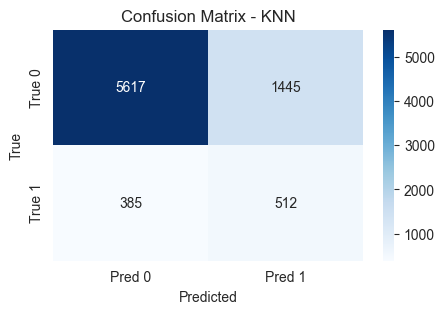

Area Under the Receiver Operating Characteristic Curve (AUC-ROC): 0.258
Area Under Precision-Recall Curve (AUC-PR): 0.258


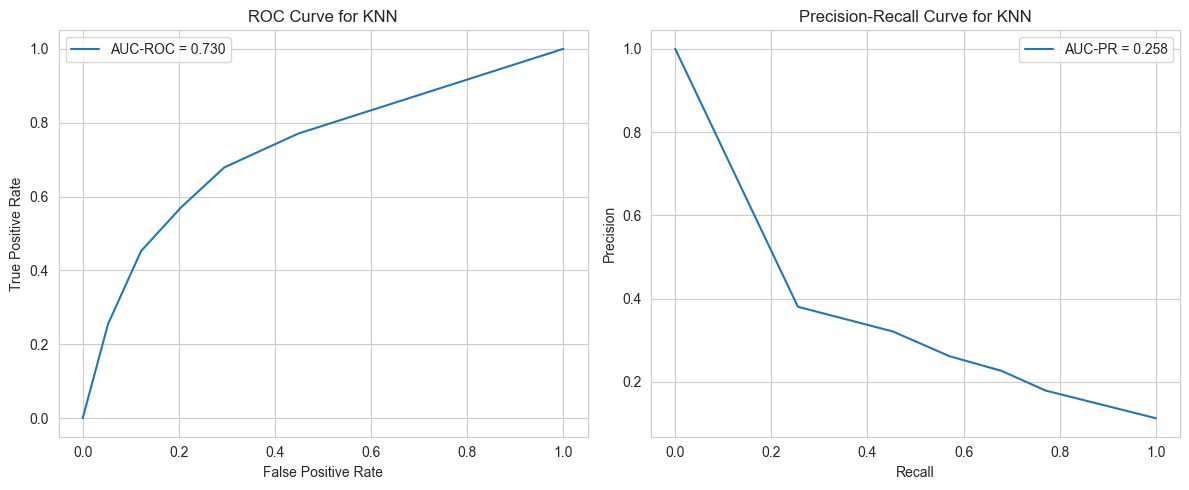

In [ ]:
# Evaluation (accuracy, recall, precision, AUC-PR, f1 score, confusion matrix)
evaluation('KNN', pred_knn, y_proba_knn, train_time_knn, pred_time_knn)

In [ ]:
# Cross validation 
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline

knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision', 'recall', 'f1', 'average_precision']

cv_results = cross_validate(knn_pipeline, X_train_imb, y_train_imb, cv=cv, scoring=scoring)

print("Cross-Validation (5-fold)")
for metric in scoring:
       print(metric.capitalize(), np.mean(cv_results[f'test_{metric}']))


Cross-Validation (5-fold)
Accuracy 0.8899534845301978
Precision 0.5231217976663691
Recall 0.2694354766649961
F1 0.35523600494845287
Average_precision 0.31054559339517523


#### Logistic Regression

In [ ]:
# Default values: penalty='l2', max_iter=100
lr_basic = LogisticRegression(random_state=42)

start_train_lr = time.time()
lr_basic.fit(X_train_scaled, y_train_model)
train_time_lr= time.time() - start_train_lr

start_pred_lr = time.time()
pred_lr = lr_basic.predict(X_test_scaled)
y_proba_lr = lr_basic.predict_proba(X_test_scaled)[:, 1]
pred_time_lr = time.time() - start_pred_lr

Accuracy:  0.7993466515893957
Recall:  0.5451505016722408
Precision:  0.29141835518474374
F1 score:  0.37980582524271844
Confusion matrix:



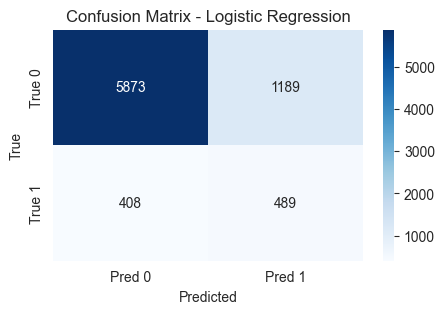

Area Under the Receiver Operating Characteristic Curve (AUC-ROC): 0.335
Area Under Precision-Recall Curve (AUC-PR): 0.335


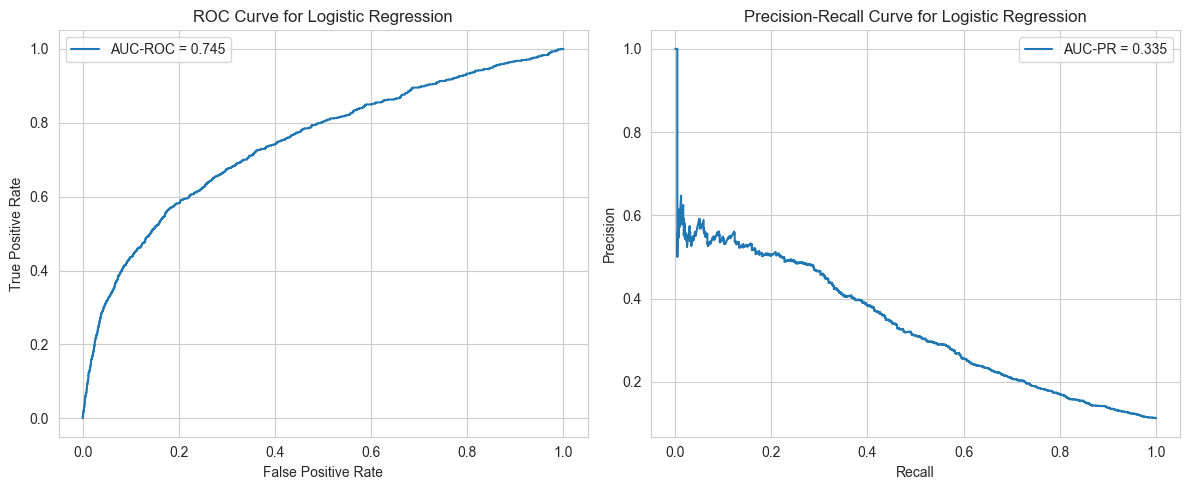

                          Feature  Importance  Coefficient
7                    emp.var.rate    2.456315    -2.456315
10                      euribor3m    1.504251     1.504251
8                  cons.price.idx    0.950230     0.950230
28    education_university.degree    0.840472    -0.840472
26          education_high.school    0.745287    -0.745287
30              contact_telephone    0.688783    -0.688783
12                job_blue-collar    0.627968    -0.627968
40                day_of_week_mon    0.592082    -0.592082
5                 never_contacted    0.558474    -0.558474
42                day_of_week_tue    0.513690    -0.513690
41                day_of_week_thu    0.511426    -0.511426
27  education_professional.course    0.491224    -0.491224
37                      month_nov    0.467160    -0.467160
25             education_basic.9y    0.459441    -0.459441
36                      month_may    0.457113    -0.457113
43                day_of_week_wed    0.441353    -0.4413

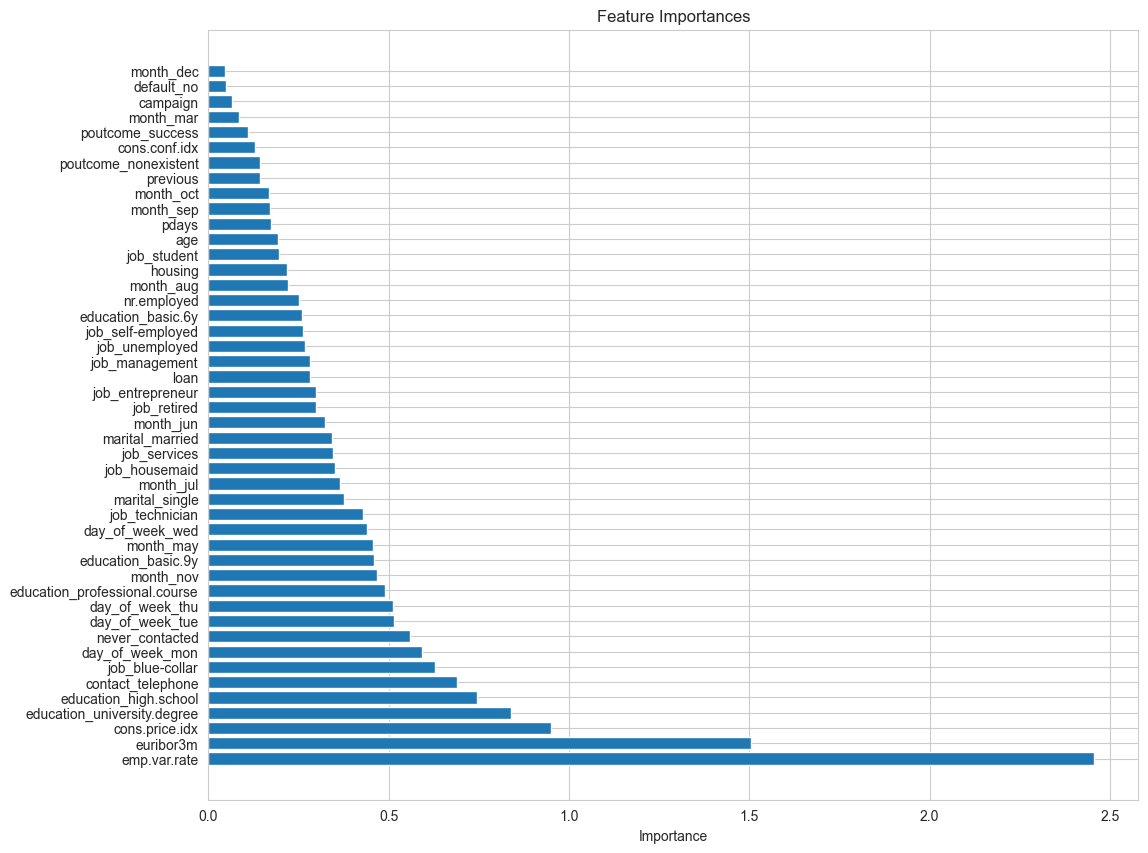

In [ ]:
evaluation('Logistic Regression', pred_lr, y_proba_lr, train_time_lr, pred_time_lr)
coefficients = lr_basic.coef_[0]
importance_df = pd.DataFrame({
    'Feature': X_train_model.columns,
    'Importance': np.abs(coefficients),
    'Coefficient': coefficients
}).sort_values(by='Importance', ascending=False).
print(importance_df)

plt.figure(figsize=(12, 10))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()

#### Decision Tree

In [ ]:
# Default values: criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1
tree_basic = DecisionTreeClassifier(random_state=42)

start_train_tree = time.time()
tree_basic = tree_basic.fit(X_train_model, y_train_model)
train_time_tree= time.time() - start_train_tree

start_pred_tree = time.time()
pred_tree = tree_basic.predict(X_test_model)
y_proba_tree  = tree_basic.predict_proba(X_test_model)[:, 1]
pred_time_tree = time.time() - start_pred_tree

Accuracy:  0.8399296394019349
Recall:  0.38461538461538464
Precision:  0.3233364573570759
F1 score:  0.3513238289205703
Confusion matrix:



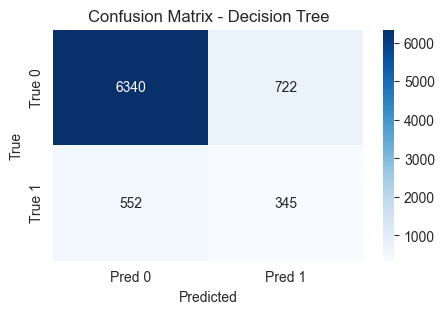

Area Under the Receiver Operating Characteristic Curve (AUC-ROC): 0.196


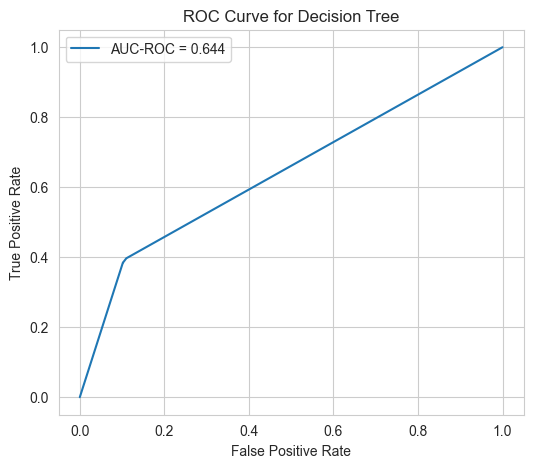

Area Under Precision-Recall Curve (AUC-PR): 0.196


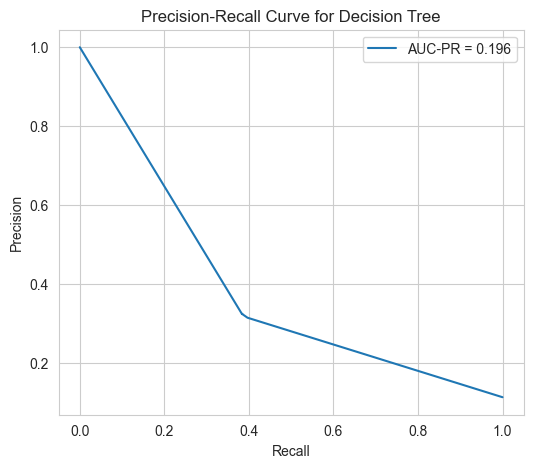

                          Feature  Importance
11                    nr.employed    0.202244
3                        campaign    0.193253
10                      euribor3m    0.190294
0                             age    0.100531
9                   cons.conf.idx    0.055582
30              contact_telephone    0.020728
1                         housing    0.016061
8                  cons.price.idx    0.012667
22                marital_married    0.012627
28    education_university.degree    0.012067
6                        previous    0.011450
2                            loan    0.011125
38                      month_oct    0.011085
26          education_high.school    0.010688
23                 marital_single    0.010118
12                job_blue-collar    0.009774
40                day_of_week_mon    0.009774
20                 job_technician    0.009191
29                     default_no    0.008596
43                day_of_week_wed    0.008541
42                day_of_week_tue 

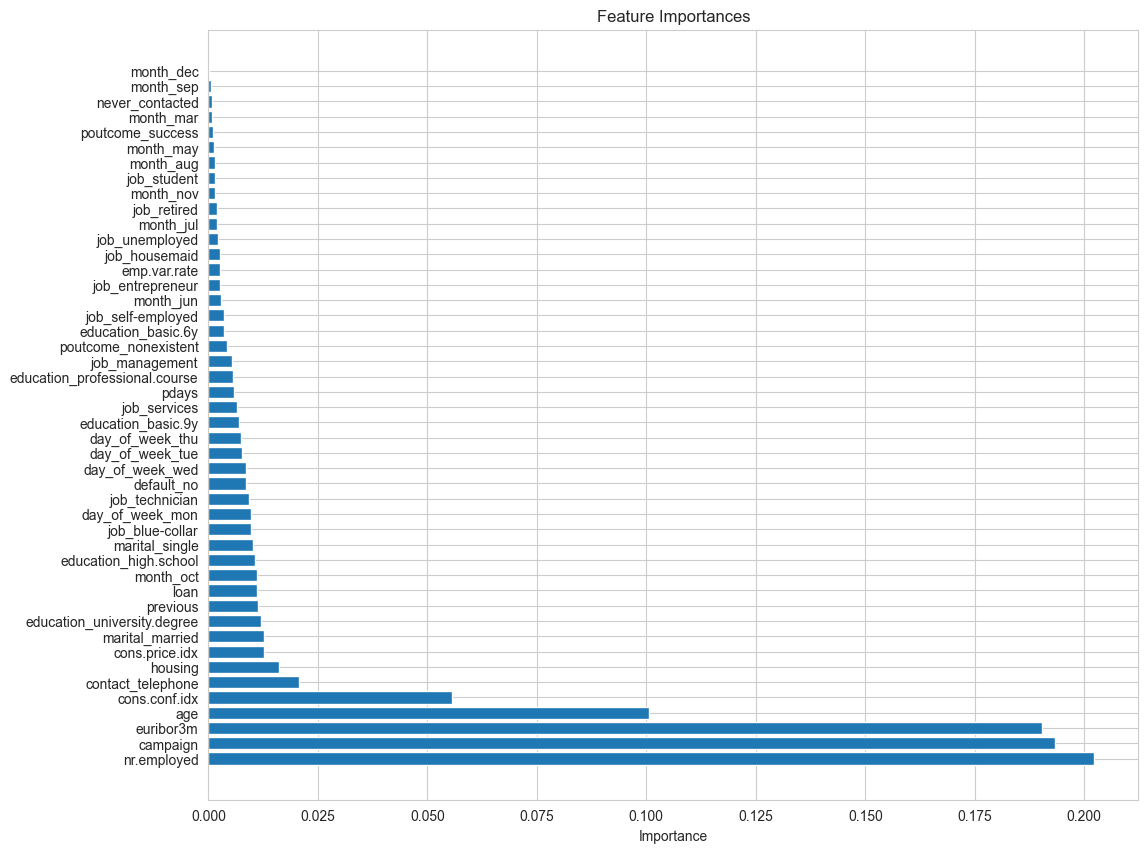

In [ ]:
# Evaluation (accuracy, recall, precision, AUC-PR, f1 score, confusion matrix)
evaluation('Decision Tree', pred_tree, y_proba_tree, train_time_tree, pred_time_tree)
feature_names = X_train_model.columns
importances = tree_basic.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

# Plot feature importances
plt.figure(figsize=(12, 10))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()

#### Naive Bayes

In [ ]:
nb_basic = GaussianNB()

start_train_nb = time.time()
nb_basic.fit(X_train_model, y_train_model)
train_time_nb= time.time() - start_train_nb

start_pred_nb = time.time()
pred_nb = nb_basic.predict(X_test_model)
y_proba_nb  = nb_basic.predict_proba(X_test_model)[:, 1]
pred_time_nb = time.time() - start_pred_nb

Accuracy:  0.8483477823847217
Recall:  0.5351170568561873
Precision:  0.3779527559055118
F1 score:  0.44300876788186433
Confusion matrix:



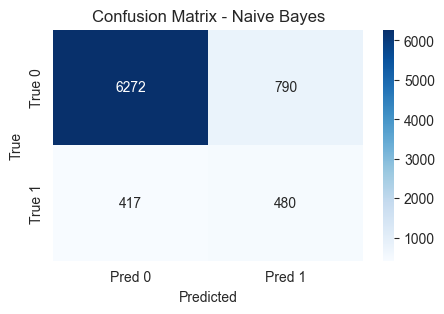

Area Under Precision–Recall Curve (AUC-PR): 0.372


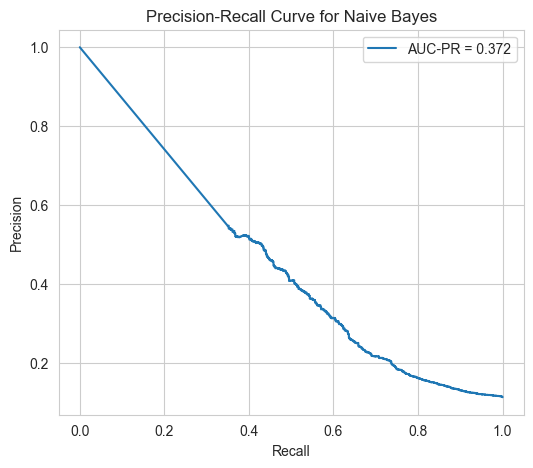

In [ ]:
evaluation('Naive Bayes', pred_nb, y_proba_nb, train_time_nb, pred_time_nb)

#### Support Vector Machines

In [ ]:
# Default values: C=1.0, kernel='rbf', gamma='scale'
svm_basic = SVC(probability=True, random_state=42)

start_train_svm = time.time()
svm_basic.fit(X_train_scaled, y_train_model)
train_time_svm = time.time() - start_train_svm

start_pred_svm = time.time()
pred_svm= svm_basic.predict(X_test_scaled)
y_proba_svm = svm_basic.predict_proba(X_test_scaled)[:, 1]
pred_time_svm = time.time() - start_pred_svm

Accuracy:  0.8158060057796206
Recall:  0.48940914158305465
Precision:  0.3033863165169316
F1 score:  0.37457337883959047
Confusion matrix:



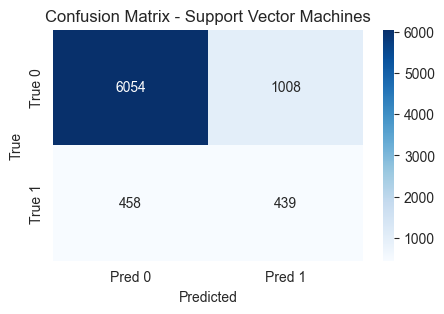

Area Under the Receiver Operating Characteristic Curve (AUC-ROC): 0.298
Area Under Precision-Recall Curve (AUC-PR): 0.298


TypeError: tight_layout() takes 0 positional arguments but 1 was given

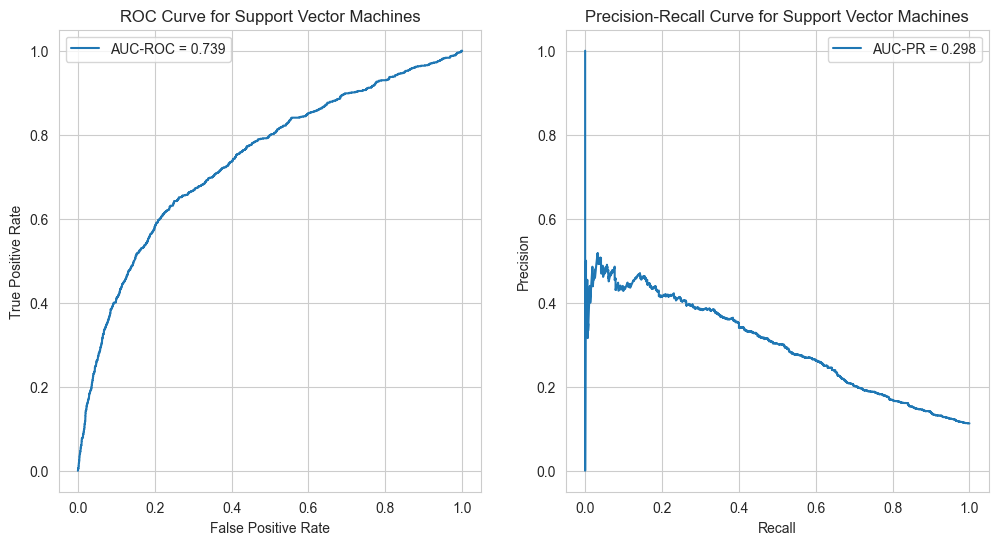

In [ ]:
evaluation('Support Vector Machines', pred_svm, y_proba_svm, train_time_svm, pred_time_svm)

#### 4.3 Baseline models comparision

In [ ]:
results_df = pd.DataFrame(results)
if not results_df.empty:
    results_df = results_df.sort_values(by='AUC-PR', ascending=False).reset_index(drop=True)
results_df

,Model,Training time,Prediction time,Accuracy,Precision,Recall,F1 Score,AUC-ROC,AUC-PR
0,Logistic Regression,0.438781,0.00000,0.799347,0.291418,0.545151,0.379806,0.745064,0.334776
1,KNN,0.027119,1.10128,0.770072,0.261625,0.570792,0.358795,0.729588,0.258171


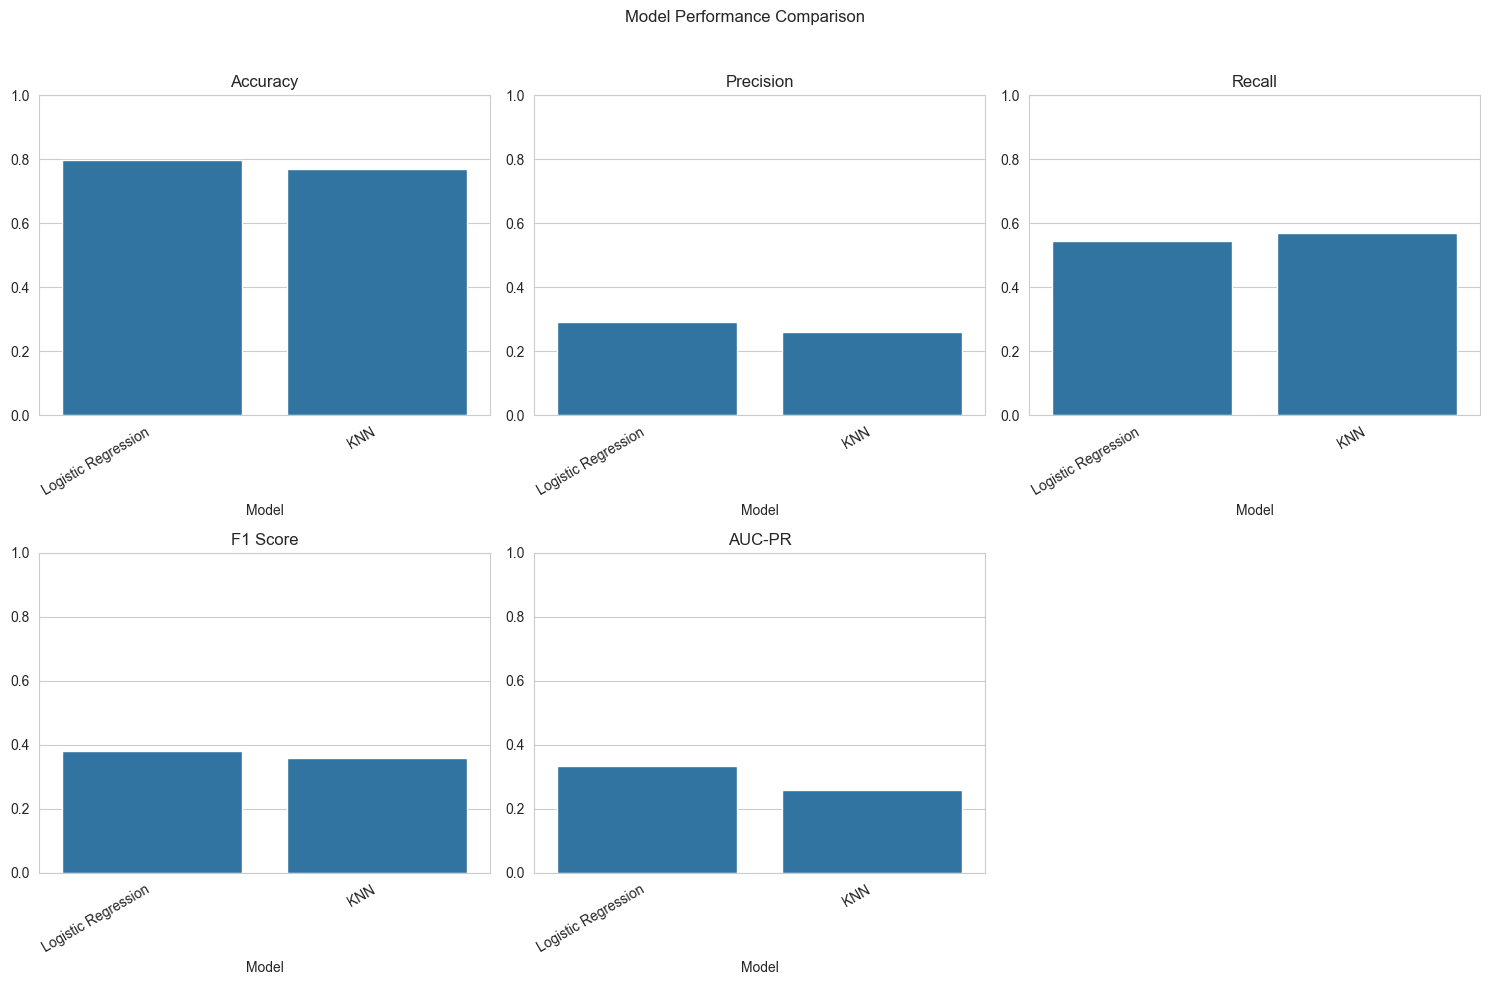

In [ ]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-PR']

plt.figure(figsize=(15, 10))
plt.suptitle('Model Performance Comparison')
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    sns.barplot(data=results_df, x='Model', y=metric)
    plt.title(metric)
    plt.ylabel('')
    plt.ylim(0, 1)
    plt.xticks(rotation=30, ha='right')
plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.show()


### 4.4 Hyperparameter Tuning for Baseline models
- TODO: Define hyperparameter search space
- TODO: Apply Grid Search or Random Search
- TODO: Use cross-validation for tuning

#### Logistic Regression

In [ ]:
print(lr_basic.get_params().keys())

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])


In [ ]:
param_lr = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-3, 3, 10),
    'solver': ['saga'],
    'max_iter': [5000, 10000]
}

In [ ]:
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTETomek(random_state=42)),
    ('model', LogisticRegression(random_state=42))
])

lr_rs = RandomizedSearchCV(pipe_lr, param_lr, n_iter=20, cv=5, scoring='average_precision', random_state=42, n_jobs=-1)

start_time_lr_rs = time.time()
lr_rs.fit(X_train_imb, y_train_imb)
train_time_lr_rs = time.time() - start_time_lr_rs

best_lr = lr_rs.best_estimator_
print("Best params:", lr_rs.best_params_)
print("Best AUC-PR:", lr_rs.best_score_)

Best params: {'solver': 'saga', 'penalty': 'l2', 'max_iter': 10000, 'C': np.float64(10.0)}
Best AUC-PR: 0.401649646521243


Accuracy:  0.9017464505591155
Recall:  0.1750278706800446
Precision:  0.7889447236180904
F1 score:  0.2864963503649635
Confusion matrix:



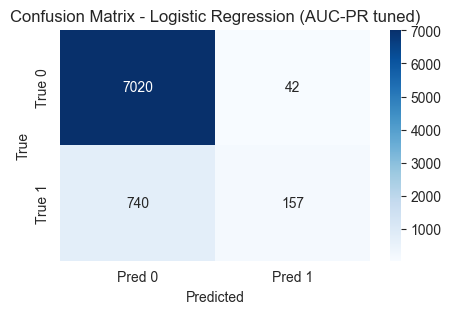

Area Under Precision–Recall Curve (AUC-PR): 0.461


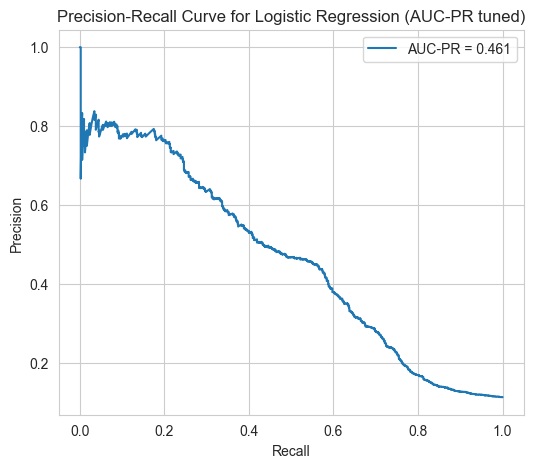

In [ ]:
start_pred_lr_rs = time.time()
y_pred_best_lr = best_lr.predict(X_test_scaled)
y_proba_best_lr = best_lr.predict_proba(X_test_scaled)[:, 1]
pred_time_lr_rs = time.time() - start_pred_lr_rs

evaluation("Logistic Regression (AUC-PR tuned)", y_pred_best_lr, y_proba_best_lr, train_time_lr_rs, pred_time_lr_rs)

#### KNN

In [ ]:
print(knn_basic.get_params().keys())

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])


In [ ]:
param_knn = {
    'n_neighbors': [3, 5, 10, 15, 20, 50],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

In [ ]:
knn_pipe =Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTETomek(random_state=42)),
    ('model', KNeighborsClassifier())
])

knn_gs = GridSearchCV(knn_pipe, param_knn, cv=5,  scoring='average_precision')
start_time_knn_gs = time.time()
knn_gs_fit = knn_gs.fit(X_train_imb, y_train_imb)
train_time_knn_gs = time.time() - start_time_knn_gs
knn_best = knn_gs.best_estimator_

print("The best parameters:", knn_gs.best_params_)
print(f"The best AUC-PR: {knn_gs.best_score_:.4f}")


ValueError: Invalid parameter 'metric' for estimator Pipeline(steps=[('scaler', StandardScaler()),
                ('smote', SMOTETomek(random_state=42)),
                ('model', KNeighborsClassifier())]). Valid parameters are: ['memory', 'steps', 'transform_input', 'verbose'].

Accuracy:  0.904887548687021
Recall:  0.2530657748049052
Precision:  0.7229299363057324
F1 score:  0.374896779521057
Confusion matrix:



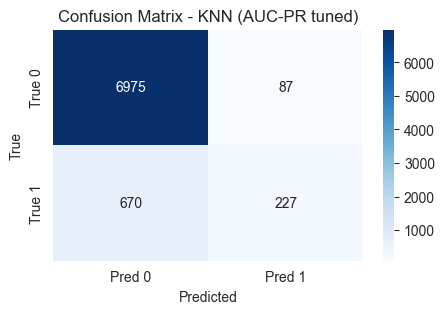

Area Under Precision–Recall Curve (AUC-PR): 0.464


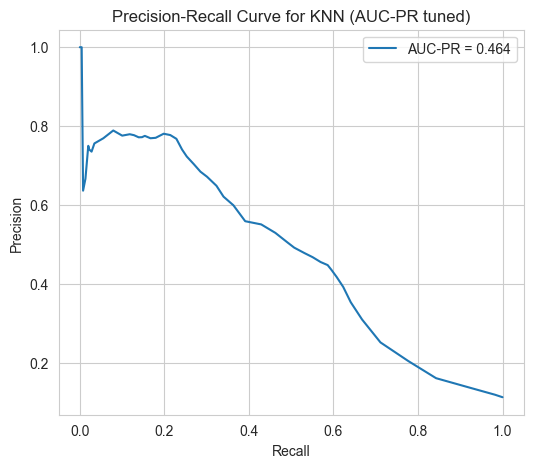

In [ ]:
start_pred_knn_gs = time.time()
y_pred_best = knn_best.predict(X_test_scaled)
y_proba_best = knn_best.predict_proba(X_test_scaled)[:, 1]
pred_time_knn_gs = time.time() - start_pred_knn_gs

evaluation("KNN (AUC-PR tuned)", y_pred_best, y_proba_best, train_time_knn_gs, pred_time_knn_gs)

#### Decision Tree


In [ ]:
print(tree_basic.get_params().keys())

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'monotonic_cst', 'random_state', 'splitter'])


In [ ]:
param_tree= {
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20)
}

In [ ]:
tree_pipe = Pipeline([
    ('smote', SMOTETomek(random_state=42)),
    ('model', DecisionTreeClassifier(random_state=42))
])

tree_rs = RandomizedSearchCV(tree_pipe, param_tree, n_iter=20, cv=5, scoring='average_precision', random_state=42, n_jobs=-1)

start_time_tree_rs = time.time()
tree_rs.fit(X_train_imb, y_train_imb)
train_time_tree_rs = time.time() - start_time_tree_rs

best_tree = tree_rs.best_estimator_
print("Best params:", tree_rs.best_params_)
print("Best AUC-PR:", tree_rs.best_score_)

Best params: {'max_depth': 7, 'min_samples_leaf': 15, 'min_samples_split': 12}
Best AUC-PR: 0.43072113324027306


Accuracy:  0.8996105038321397
Recall:  0.2787068004459309
Precision:  0.6218905472636815
F1 score:  0.3849114703618168
Confusion matrix:



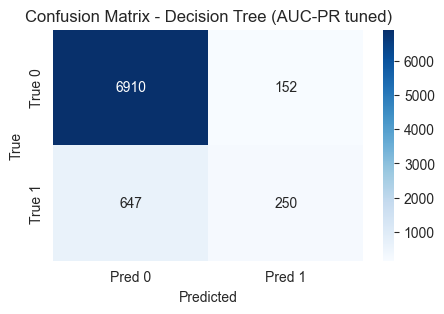

Area Under Precision–Recall Curve (AUC-PR): 0.455


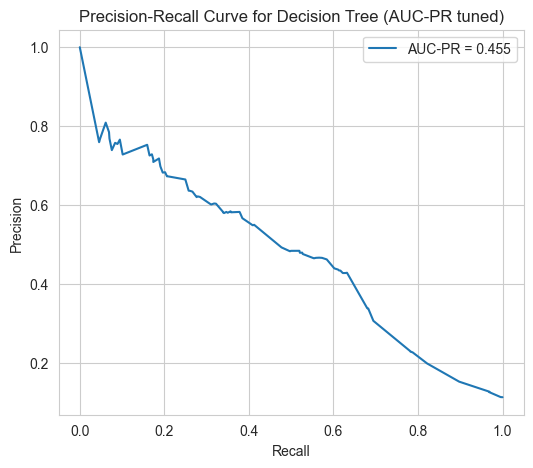

In [ ]:
start_pred_tree_rs = time.time()
y_pred_best_tree = best_tree.predict(X_test_scaled)
y_proba_best_tree = best_tree.predict_proba(X_test_scaled)[:, 1]
pred_time_tree_rs = time.time() - start_pred_tree_rs

evaluation("Decision Tree (AUC-PR tuned)", y_pred_best_tree, y_proba_best_tree, train_time_tree_rs, pred_time_tree_rs)

### 4.5 Ensemble Methods
- TODO: Create ensemble models (voting, stacking, blending)
- TODO: Combine best performing models

In [ ]:
# Ensemble models
# TODO: Implement ensemble techniques

#### Random Forest

In [ ]:
# Default values: n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1
forest_basic = RandomForestClassifier(random_state=42)

start_train_forest = time.time()
forest_basic.fit(X_train_model, y_train_model)
train_time_forest= time.time() - start_train_forest

start_pred_forest = time.time()
pred_forest = forest_basic.predict(X_test_model)
y_proba_forest = forest_basic.predict_proba(X_test_model)[:, 1]
pred_time_forest = time.time() - start_pred_forest

Accuracy:  0.8800100515140094
Recall:  0.43032329988851725
Precision:  0.4650602409638554
F1 score:  0.4470179502026636
Confusion matrix:



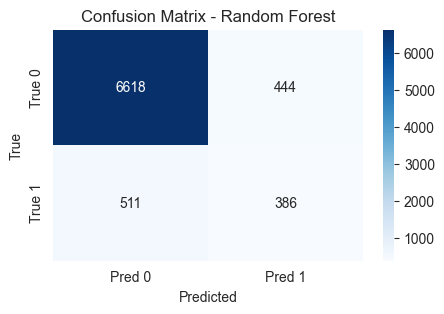

Area Under the Receiver Operating Characteristic Curve (AUC-ROC): 0.393


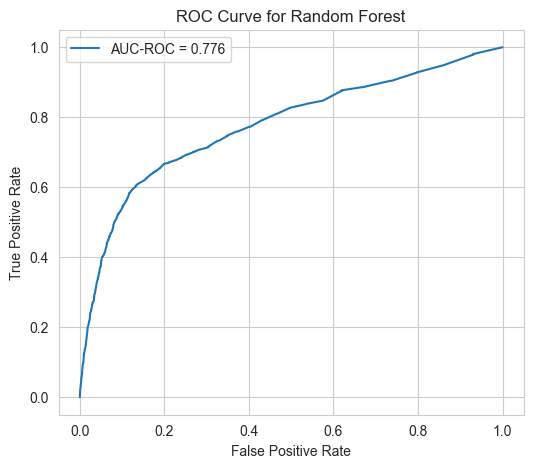

Area Under Precision-Recall Curve (AUC-PR): 0.393


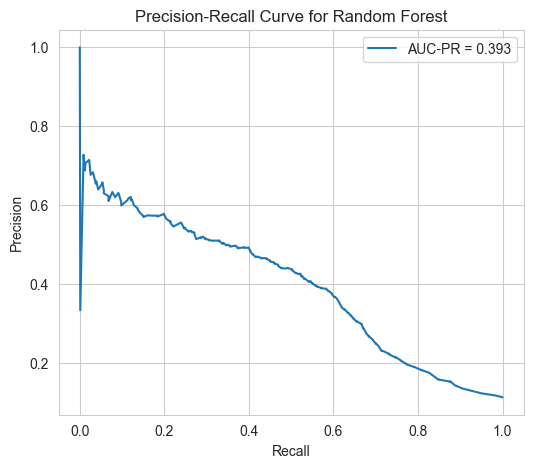

                          Feature  Importance
10                      euribor3m    0.170881
0                             age    0.123228
3                        campaign    0.115833
11                    nr.employed    0.071085
7                    emp.var.rate    0.042004
9                   cons.conf.idx    0.035589
8                  cons.price.idx    0.028543
30              contact_telephone    0.028072
1                         housing    0.022037
4                           pdays    0.019563
22                marital_married    0.018520
40                day_of_week_mon    0.017918
12                job_blue-collar    0.016799
43                day_of_week_wed    0.016086
28    education_university.degree    0.016025
2                            loan    0.016008
29                     default_no    0.015975
6                        previous    0.015738
41                day_of_week_thu    0.015398
26          education_high.school    0.015034
23                 marital_single 

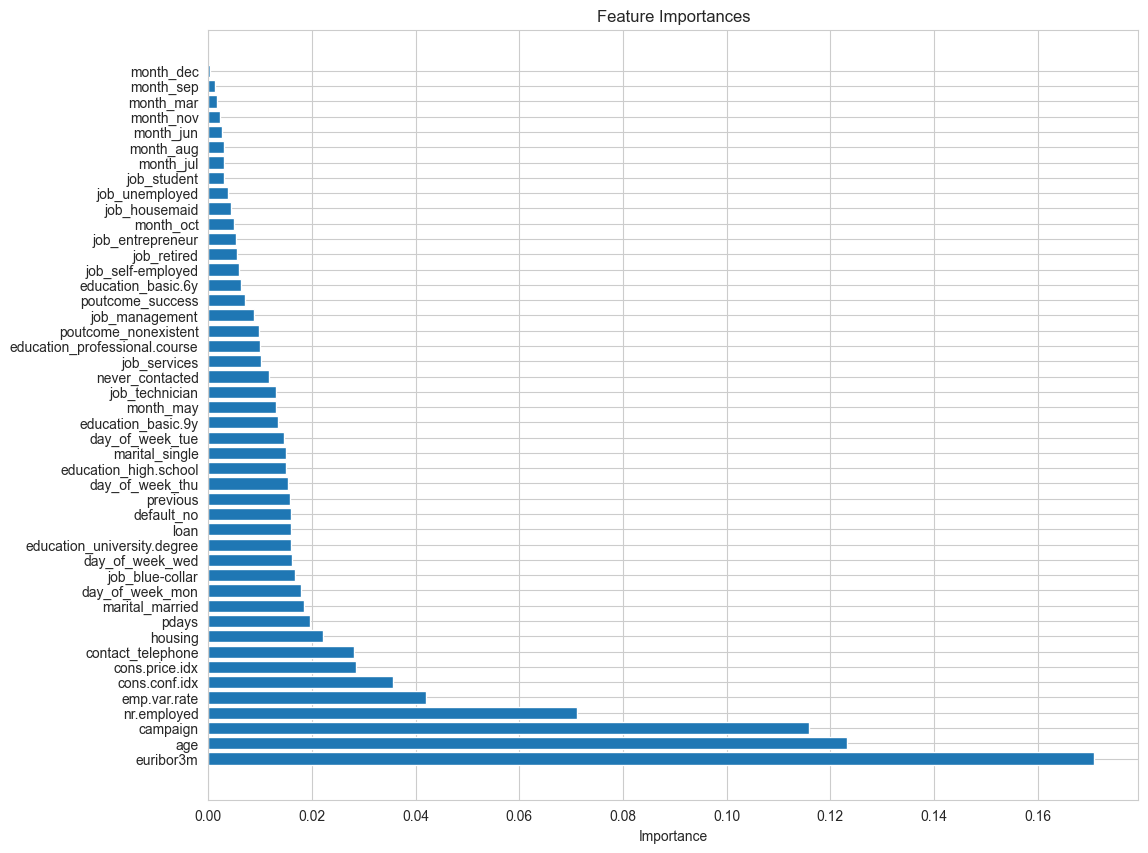

In [ ]:
evaluation("Random Forest", pred_forest, y_proba_forest, train_time_forest, pred_time_forest)
feature_names = X_train_model.columns
importances = forest_basic.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

# Plot feature importances
plt.figure(figsize=(12, 10))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()

#### Gradient Boosting

In [ ]:
# Default values: learning_rate=0.1, n_estimators=100, subsample=1.0, max_depth=3, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1
gb_basic = GradientBoostingClassifier(random_state=42)

start_train_gb = time.time()
gb_basic.fit(X_train_model, y_train_model)
train_time_gb= time.time() - start_train_gb

start_pred_gb = time.time()
pred_gb = gb_basic.predict(X_test_model)
y_proba_gb = gb_basic.predict_proba(X_test_model)[:, 1]
pred_time_gb = time.time() - start_pred_gb

Accuracy:  0.8728483477823847
Recall:  0.5451505016722408
Precision:  0.4473924977127173
F1 score:  0.4914572864321608
Confusion matrix:



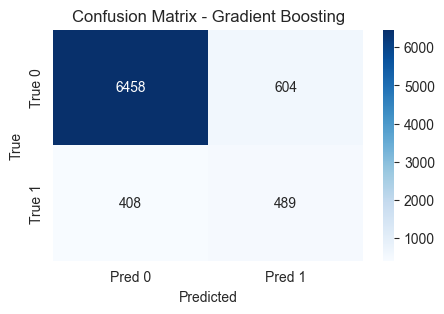

Area Under the Receiver Operating Characteristic Curve (AUC-ROC): 0.437


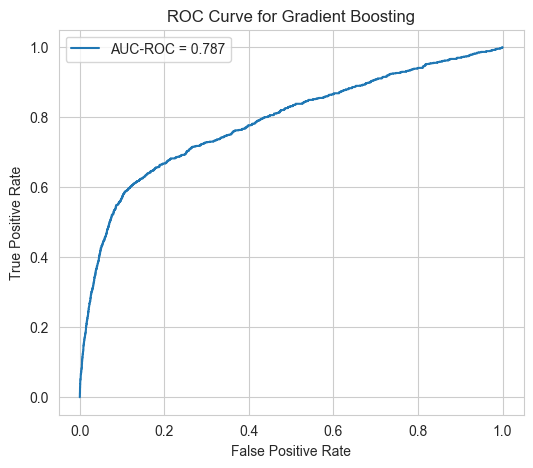

Area Under Precision-Recall Curve (AUC-PR): 0.437


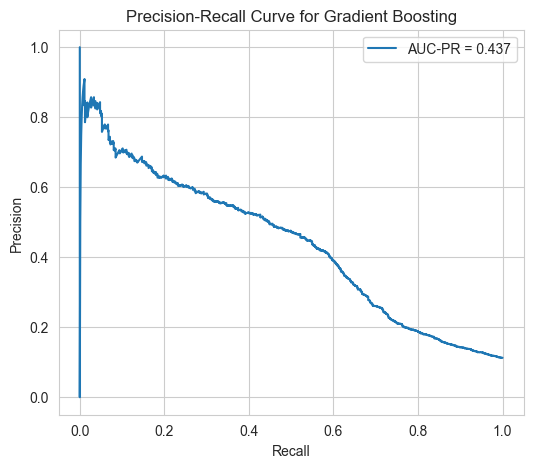

                          Feature  Importance
3                        campaign    0.294021
11                    nr.employed    0.232994
10                      euribor3m    0.168821
9                   cons.conf.idx    0.066451
30              contact_telephone    0.034243
40                day_of_week_mon    0.017162
36                      month_may    0.016002
2                            loan    0.014810
8                  cons.price.idx    0.013084
12                job_blue-collar    0.011925
38                      month_oct    0.011500
42                day_of_week_tue    0.010908
41                day_of_week_thu    0.010815
4                           pdays    0.010593
20                 job_technician    0.009760
7                    emp.var.rate    0.008515
43                day_of_week_wed    0.006172
18                   job_services    0.006123
5                 never_contacted    0.005935
1                         housing    0.005877
15                 job_management 

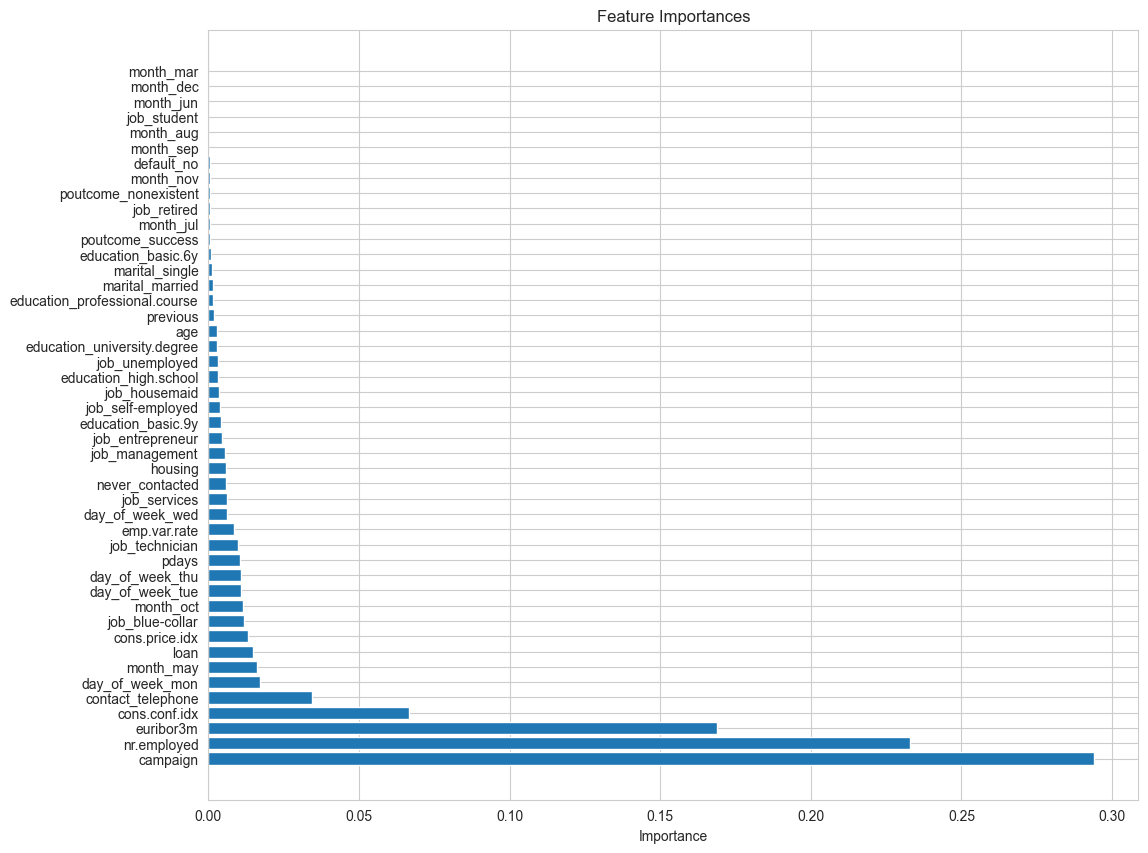

In [ ]:
evaluation("Gradient Boosting", pred_gb, y_proba_gb, train_time_gb, pred_time_gb)
feature_names = X_train_model.columns
importances = gb_basic.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

# Plot feature importances
plt.figure(figsize=(12, 10))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()

---
## 5. Evaluation

### 5.1 Model Performance Metrics
- TODO: Calculate accuracy, precision, recall, F1-score
- TODO: Generate ROC curves and calculate AUC
- TODO: Create confusion matrices
- TODO: Calculate business-relevant metrics (cost/benefit analysis)

In [ ]:
# Model evaluation metrics
# TODO: Calculate and compare all metrics across models

In [ ]:
# Visualize model performance
# TODO: Create ROC curves, precision-recall curves
# TODO: Create confusion matrices
# TODO: Create comparison charts

### 5.2 Model Interpretation
- TODO: Analyze feature importance
- TODO: Interpret model predictions
- TODO: Validate model behavior

In [ ]:
# Feature importance analysis
# TODO: Extract and visualize feature importance from models

In [ ]:
# Model interpretation
# TODO: Use SHAP, LIME, or other interpretation methods if applicable

### 5.3 Model Validation
- TODO: Perform cross-validation
- TODO: Test on holdout set
- TODO: Check for overfitting/underfitting

In [ ]:
# Cross-validation
# TODO: Perform k-fold cross-validation on best models

In [ ]:
# Final model evaluation on test set
# TODO: Evaluate final model(s) on unseen test data

### 5.4 Business Impact Assessment
- TODO: Translate model performance to business value
- TODO: Calculate expected ROI or cost savings
- TODO: Provide actionable recommendations

In [ ]:
# Business impact analysis
# TODO: Calculate business metrics (conversion rate improvement, cost reduction, etc.)

---
## 6. Conclusions and Recommendations

### 6.1 Summary of Findings
- TODO: Summarize key insights from data exploration
- TODO: Summarize model performance
- TODO: Identify most important predictive features

### 6.2 Best Model Selection
- TODO: Select and justify the best model
- TODO: Document model strengths and limitations

### 6.3 Recommendations
- TODO: Provide actionable business recommendations
- TODO: Suggest customer prioritization strategy
- TODO: Recommend campaign optimization strategies

### 6.4 Future Work
- TODO: Suggest model improvements
- TODO: Identify additional data needs
- TODO: Propose deployment strategy

### 6.5 Lessons Learned
- TODO: Document challenges faced
- TODO: Share insights from the project
- TODO: Note what would be done differently

---

## Project Notes and Team Collaboration

### Team Members
- TODO: List team members and responsibilities

Julia Kardasz 1250264

### Project Timeline
- TODO: Document project milestones and deadlines

### References
- TODO: Add references to papers, documentation, and resources used

---
*This notebook follows the CRISP-DM methodology for data mining projects*